# Chapter 3: Convolutional Neural Networks

## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

import time
import pandas as pd
import numpy as np
from scipy import stats   #ttest

# ROC metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import balanced_accuracy_score 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split

# Plotting figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm

# Import tensorFlow / Keras
import tensorflow as tf
from tensorflow import keras

# Print the versions of TensorFlow/Keras. Version superior to 2.x are required
print('TensorFlow version:', tf.__version__)
print('Keras version:',keras.__version__)

TensorFlow version: 2.6.0
Keras version: 2.6.0


## Utility functions

1. `femaleMiceWeightSimulation`
2. `MHT_Significant_values`
3. `DL_Significant_values`
4. `significance_report`

In [2]:
# 1) Download the female mice control population

url = "https://raw.githubusercontent.com/genomicsclass/dagdata/master/inst/extdata/femaleControlsPopulation.csv"
df = pd.read_csv(url)
population = df.to_numpy().flatten()

# 2) Function:
def femaleMiceWeightSimulation(N = 12, 
                               m = 100, 
                               p0 = 0.90, 
                               delta = 3,  
                               seed = 42):
  '''
  Function to create the X image representation and Y response. 
  Additionally, list of pvalues, LBBF
  Input
  -----
  N = 12               # Sample size
  m = 100              # Number of test
  p0 = 0.90            # 10% of diets work, 90% don't
  delta = 3            # Effect size


  Output: Dictionary with the following elements
  ------
  X: matrix dimension mxm with the lbf quotients
  Y: Array with the real values of the null hypothesis (1) null is false, (0) otherwiese
  p_value: List of p-values
  LBBF: list of Lower bound byes factor
  ES: Vector with the apllied vector size.
  P0: Proportion null hypothesis is true
  '''
    
  m0 = np.int16(np.ceil(m*p0))  # Number of test where null hypothesis is true (s)
  m1 = np.int16(m-m0)           # Number of test where null hypothesis is false (saved like int)

  # Ground truth
  nullHypothesis = np.append(np.ones(m0, dtype=bool),np.zeros(m1, dtype=bool) )

  # Sample
  np.random.seed(seed)
  controls   = np.random.choice(population, size = N*m, replace=True).reshape((m,N))
  treatments = np.random.choice(population, size = N*m, replace=True).reshape((m,N))
  treatments[np.logical_not(nullHypothesis),] = treatments[np.logical_not(nullHypothesis),] + delta

  # Computing the pvalues: 
  p_values = np.array([result[1] for result in list(map(stats.ttest_ind, controls, treatments))])

  # Copy the vector of p-values and null hypothesis
  p_values_sorted = p_values.copy()
  H = nullHypothesis.copy()

  # Then, we order the vectors of p-values and null_hyporhesis
  o = np.argsort(p_values)
  p_values_sorted = p_values_sorted[o]
  H = H[o]
    
  # Response: Positive class: 1 Detect H0 false (H1 true)
  Y = np.logical_not(H).astype(int)

  # We compute the results under the following procedures:
   
  # 3) Bayesian approach (LBBF)
  lbf = np.where(p_values_sorted < (1/np.exp(1)), -np.exp(1)*p_values_sorted*np.log(p_values_sorted), 1) # Bayes Factor Lower Boun

  # To compute the quotient lbf[t]/lbf, we create a lambda function
  div_lbf = lambda t: lbf[t]/lbf

  # Then, the image is compute for each vector inptu
  image_lbf = np.array([div_lbf(xi) for xi in np.arange(0,m)]).T

  # We compute the maximum lbf quotient, in order to standarize the matrix in the range 0 and 1
  max_lbf = np.max(image_lbf)

  # Input of the ANNs - CNNs
  X = image_lbf/max_lbf
  # otuput of the function
  output_dict = {'X': X,  'Y': Y, 
                 'p_value': p_values_sorted,  'LBBF':  lbf,
                 'ES': delta, 'Prop_H0': p0}

  return output_dict

In [3]:
def MHT_Significant_values(v_grid,
                           a_pvalues,
                           a_nullHypothesis,
                           n_m,
                           n_sim = 1):
  '''
  Function that computes the performance under several models:

  Input
  -----



  Output
  -----

  roc_values: FPR and TPR
  prec_recall: Precision and recall
  counts: R, fp, tp, fn, tn, type-II error  
  '''

  # Ravel the vectors of v_pvalues and v_nullHypothesis

  v_pvalues = a_pvalues.ravel()
  v_nullHypothesis = a_nullHypothesis.ravel()

  roc_values_HT = [[0,0]]
  prec_recall_HT = [[0,1]]
  counts_HT = [[0, 0, 0, np.sum(v_nullHypothesis), len(v_nullHypothesis) - np.sum(v_nullHypothesis),1]]
  
  for _alpha in v_grid:
    call = np.where(v_pvalues <= _alpha, False, True)
    code_call = np.logical_not(call).astype(int)
    tn, fp, fn, tp = confusion_matrix(v_nullHypothesis, code_call).ravel()
    R = fp + tp
    fpr = fp/(fp+tn)
    tpr = tp/(tp+fn)
    #prec = tp/(tp + fp)
    if fp == 0:
      prec = 1
    else:
      prec = tp/(tp + fp)
    # Type-II error
    fnr = fn/(fn + tp)
    roc_values_HT.append([fpr, tpr])
    prec_recall_HT.append([tpr, prec])
    counts_HT.append([R, fp, tp, fn, tn, fnr])
    # End for

  #----------------------------------------------------
  # 2) Bonferroni correction
  roc_values_Bonf = [[0,0]]
  prec_recall_Bonf = [[0,1]]
  counts_Bonf = [[0, 0, 0, np.sum(v_nullHypothesis), len(v_nullHypothesis) - np.sum(v_nullHypothesis),1]]
  for _alpha in v_grid:
    Bonf_bound = _alpha/n_m
    call = np.where(v_pvalues <= Bonf_bound, False, True)
    code_call = np.logical_not(call).astype(int)
    tn, fp, fn, tp = confusion_matrix(v_nullHypothesis, code_call).ravel()
    R = fp + tp
    fpr = fp/(fp+tn)
    tpr = tp/(tp+fn)
    #prec = tp/(tp + fp)
    if fp == 0:
      prec = 1
    else:
      prec = tp/(tp + fp)
    
    # Type-II error
    fnr = fn/(fn + tp)
    roc_values_Bonf.append([fpr, tpr])
    prec_recall_Bonf.append([tpr, prec])
    counts_Bonf.append([R, fp, tp, fn, tn, fnr])
    # End for

  #----------------------------------------------------
  # 3) Benjamini Hocheberg FDR
  
  roc_values_BH = [[0,0]]
  prec_recall_BH = [[0,1]]
  counts_BH = [[0,0,0,np.sum(v_nullHypothesis),len(v_nullHypothesis) - np.sum(v_nullHypothesis),1]]
  for _q in v_grid:
    BH_bound = np.arange(1,n_m+1)*(_q)/n_m
    BH_bound = np.tile(BH_bound,n_sim)
    call_BH_q = np.where(v_pvalues < BH_bound, False, True)
    code_call_BH_q = np.logical_not(call_BH_q).astype(int)
    tn, fp, fn, tp = confusion_matrix(v_nullHypothesis, code_call_BH_q).ravel()
    R = fp + tp
    fpr = fp/(fp + tn)
    tpr = tp/(tp+fn)
    if fp == 0:
      prec = 1
    else:
      prec = tp/(tp + fp)
    
    # Type-II error
    fnr = fn/(fn + tp)
    roc_values_BH.append([fpr, tpr])
    prec_recall_BH.append([tpr, prec])
    counts_BH.append([R, fp, tp, fn, tn, fnr])
    # End for

  # Outout_dict
  output_dict = {'roc_values_HT': roc_values_HT, 'prec_recall_HT': prec_recall_HT, 'counts_HT' : counts_HT,
                 'roc_values_Bonf': roc_values_Bonf, 'prec_recall_Bonf': prec_recall_Bonf, 'counts_Bonf' : counts_Bonf,
                 'roc_values_BH': roc_values_BH, 'prec_recall_BH': prec_recall_BH, 'counts_BH' : counts_BH}

  return output_dict

In [4]:
def DL_Significant_values(v_grid, a_test, a_score):

  '''
  Function that computes the performance under several models:

  Input
  -----



  Output
  -----

  roc_values: FPR and TPR
  prec_recall: Precision and recall
  counts: R, fp, tp, fn, tn, type-II error  
  '''

  y_fpr, _, thresholds = roc_curve(a_test.ravel(), a_score.ravel())
   
  roc_values_DL = [[0,0]]
  prec_recall_DL = [[0,1]]
  v_nullHypothesis = a_test.ravel()
  counts_DL = [[0, 0, 0, np.sum(v_nullHypothesis),len(v_nullHypothesis) - np.sum(v_nullHypothesis), 1]]
  for tt in v_grid:

    # Create copy of the thresholds and fpr objects
    max_thr_fpr = thresholds[len(y_fpr[y_fpr <= tt]) - 1]
    y_hat = np.where(a_score >= max_thr_fpr, 1,0)
    
    tn, fp, fn, tp = confusion_matrix(v_nullHypothesis, y_hat.ravel()).ravel()
    R = fp + tp
    fpr = fp/(fp + tn)
    tpr = tp/(tp+fn)
    if fp == 0:
      prec = 1
    else:
      prec = tp/(tp + fp)
    # Type-II error
    fnr = fn/(fn + tp)
    roc_values_DL.append([fpr, tpr])
    prec_recall_DL.append([tpr, prec])
    counts_DL.append([R, fp, tp, fn, tn, fnr])
    # End for

  # Outout_dict
  output_dict = {'roc_values_DL': roc_values_DL, 'prec_recall_DL': prec_recall_DL, 'counts_DL' : counts_DL}

  return output_dict

In [5]:
def significance_report(out_trad,
                        out_ANN = None,
                        out_CNN = None):
  
  # 1) HT: Uncorrected method
  rej_HT, fp_HT, tp_HT, fn_HT,_, fnr_HT = zip(*out_trad['counts_HT'])
  fpr_HT, _ = zip(*out_trad['roc_values_HT'])

  # 2) Bonferroni
  rej_Bonf, fp_Bonf, tp_Bonf, fn_Bonf,_, fnr_Bonf = zip(*out_trad['counts_Bonf'])
  fpr_Bonf, _ = zip(*out_trad['roc_values_Bonf'])

  # 3) Benjamini Hocheberg FDR
  rej_BH, fp_BH, tp_BH, fn_BH,_, fnr_BH = zip(*out_trad['counts_BH'])
  fpr_BH, _ = zip(*out_trad['roc_values_BH'])

  if (out_ANN is not None and out_CNN is not None):
    # ANN results
    rej_ANN, fp_ANN, tp_ANN, fn_ANN,_, fnr_ANN = zip(*out_ANN['counts_DL'])
    fpr_ANN, _ = zip(*out_ANN['roc_values_DL'])
	
	  # CNN results
    rej_CNN, fp_CNN, tp_CNN, fn_CNN,_, fnr_CNN = zip(*out_CNN['counts_DL'])
    fpr_CNN, _ = zip(*out_CNN['roc_values_DL'])

    data_rejections   = {'Uncorrected': rej_HT, 'Bonferroni': rej_Bonf, 'BH': rej_BH, 'ANN' : rej_ANN, 'CNN' : rej_CNN}
    data_typeI_error  = {'Uncorrected': fpr_HT, 'Bonferroni': fpr_Bonf, 'BH': fpr_BH, 'ANN' : fpr_ANN, 'CNN' : fpr_CNN}
    data_typeII_error = {'Uncorrected': fnr_HT, 'Bonferroni': fnr_Bonf, 'BH': fnr_BH, 'ANN' : fnr_ANN, 'CNN' : fnr_CNN}
  
  elif(out_ANN is not None and out_CNN is None):
    # ANN results
    rej_ANN, fp_ANN, tp_ANN, fn_ANN,_, fnr_ANN = zip(*out_ANN['counts_DL'])
    fpr_ANN, _ = zip(*out_ANN['roc_values_DL'])

    data_rejections   = {'Uncorrected': rej_HT, 'Bonferroni': rej_Bonf, 'BH': rej_BH, 'ANN' : rej_ANN}
    data_typeI_error  = {'Uncorrected': fpr_HT, 'Bonferroni': fpr_Bonf, 'BH': fpr_BH, 'ANN' : fpr_ANN}
    data_typeII_error = {'Uncorrected': fnr_HT, 'Bonferroni': fnr_Bonf, 'BH': fnr_BH, 'ANN' : fnr_ANN}
  
  elif(out_ANN is None and out_CNN is not None):
    # CNN results
    rej_CNN, fp_CNN, tp_CNN, fn_CNN,_, fnr_CNN = zip(*out_CNN['counts_DL'])
    fpr_CNN, _ = zip(*out_CNN['roc_values_DL'])
    
    data_rejections   = {'Uncorrected': rej_HT, 'Bonferroni': rej_Bonf, 'BH': rej_BH, 'CNN' : rej_CNN}
    data_typeI_error  = {'Uncorrected': fpr_HT, 'Bonferroni': fpr_Bonf, 'BH': fpr_BH, 'CNN' : fpr_CNN}
    data_typeII_error = {'Uncorrected': fnr_HT, 'Bonferroni': fnr_Bonf, 'BH': fnr_BH, 'CNN' : fnr_CNN}
  else:
    data_rejections   = {'Uncorrected': rej_HT, 'Bonferroni': rej_Bonf, 'BH': rej_BH}
    data_typeI_error  = {'Uncorrected': fpr_HT, 'Bonferroni': fpr_Bonf, 'BH': fpr_BH}
    data_typeII_error = {'Uncorrected': fnr_HT, 'Bonferroni': fnr_Bonf, 'BH': fnr_BH}
	
  out_dict = {'data_rejections': data_rejections,
              'data_typeI_error': data_typeI_error,
              'data_typeII_error': data_typeII_error}
              
  return out_dict

## Plotting functions

1. `plot_roc`
2. `plot_performance_metrics`
3. `plot_ROC_PRC_score`
4. `plot_DL_log_loss`
5. `plot_DL_performance_metrics`
6. `plot_relevant_parameters_train_test`
7. `plot_performance_metrics_PR_ES`

In [6]:
## 1) Plot ROC Curves

def plot_roc(labels, predictions, title, **kwargs):
  fp, tp, _ = roc_curve(labels, predictions)
  auc_val = auc(fp, tp)
  plt.plot(fp, tp, linewidth=2, label = 'AUROC  = {:.3f}'.format(auc_val),**kwargs)
  plt.plot([0, 1], [0, 1], 'k--',label='baseline', color='grey')
  plt.xlabel('False positive rate (FPR)')
  plt.ylabel('True positive rate (TPR)')
  plt.title(title)
  plt.legend(fontsize=12)
  ax = plt.gca()
  ax.set_aspect('equal')

In [7]:
def plot_performance_metrics(v_grid,
                     out_sig_grid,
                     baseline_pr,
                     title = 'Figure', 
                     out_ANN = None,
                     out_CNN = None,
                     fig_save = None):

  ext_grid = np.append(0, v_grid)

  # HT Uncorrected
  rej_HT, fp_HT, tp_HT, fn_HT,_,_ = zip(*out_sig_grid['counts_HT'])
  fpr_HT, tpr_HT = zip(*out_sig_grid['roc_values_HT'])
  recall_HT, prec_HT = zip(*out_sig_grid['prec_recall_HT'])

  # Bonferroni correction
  rej_Bonf, fp_Bonf, tp_Bonf, fn_Bonf,_,_ = zip(*out_sig_grid['counts_Bonf'])
  fpr_Bonf, tpr_Bonf = zip(*out_sig_grid['roc_values_Bonf'])
  recall_Bonf, prec_Bonf = zip(*out_sig_grid['prec_recall_Bonf'])

  # BH
  rej_BH, fp_BH, tp_BH, fn_BH,_,_ = zip(*out_sig_grid['counts_BH'])
  fpr_BH, tpr_BH = zip(*out_sig_grid['roc_values_BH'])
  recall_BH, prec_BH = zip(*out_sig_grid['prec_recall_BH'])

  if out_ANN is not None:
    # ANN results
    rej_ANN, fp_ANN, tp_ANN, fn_ANN,_,_ = zip(*out_ANN['counts_DL'])
    fpr_ANN, tpr_ANN = zip(*out_ANN['roc_values_DL'])
    recall_ANN, prec_ANN = zip(*out_ANN['prec_recall_DL'])

  if out_CNN is not None:
    # CNN results
    rej_CNN, fp_CNN, tp_CNN, fn_CNN,_,_ = zip(*out_CNN['counts_DL'])
    fpr_CNN, tpr_CNN = zip(*out_CNN['roc_values_DL'])
    recall_CNN, prec_CNN = zip(*out_CNN['prec_recall_DL'])

  fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,5))

  # Subplot Rejection
  ax1.plot(ext_grid,rej_HT,'-', color='darkviolet',label = 'Uncorrected')
  ax1.plot(ext_grid,rej_Bonf, '-', color='orange', label = 'Bonferroni')
  ax1.plot(ext_grid,rej_BH, '-', color='green' ,label = 'BH')
  if out_ANN is not None:
    ax1.plot(ext_grid,rej_ANN, '-', linewidth = 2, color='red', label = 'ANN')
  if out_CNN is not None:
    ax1.plot(ext_grid,rej_CNN, '-', linewidth = 2, color='mediumblue', label = 'CNN')
  ax1.set_title('Total Rejections')
  ax1.set(xlabel='Significant values', ylabel = 'Rejections (R)')
  ax1.legend()

  # Subplot ROC
  ax2.plot(fpr_HT,tpr_HT,'-', color='darkviolet', label = 'AUROC-UHT = {:.2f}'.format(auc(fpr_HT,tpr_HT)))
  ax2.plot(fpr_Bonf,tpr_Bonf, '-',color='orange', label = 'AUROC-Bonf = {:.2f}'.format(auc(fpr_Bonf,tpr_Bonf)))
  ax2.plot(fpr_BH,tpr_BH, '-' , color='green' , label = 'AUROC-BH = {:.2f}'.format(auc(fpr_BH,tpr_BH)))
  if out_ANN is not None:
    ax2.plot(fpr_ANN,tpr_ANN,'-', linewidth = 2, color='red', label = 'AUROC-ANN = {:.2f}'.format(auc(fpr_ANN,tpr_ANN)))
  if out_CNN is not None:
    ax2.plot(fpr_CNN,tpr_CNN,'-', linewidth = 2, color='mediumblue', label = 'AUROC-CNN = {:.2f}'.format(auc(fpr_CNN,tpr_CNN)))
  ax2.plot(np.linspace(0, 1*np.max(fpr_HT), 100),
         np.linspace(0, 1*np.max(fpr_HT), 100),
         label='baseline',
         linestyle='--',
         color = 'grey')
  ax2.set_title('ROC Curve')
  ax2.set(xlabel='False positive rate (FPR)', ylabel='True positive rate (TPR)')
  ax2.set_ylim([0, 1.05])
  ax2.legend()

  # Subplot Precision-Recall
  ax3.plot(recall_HT,prec_HT,'-', color='darkviolet', label = 'AUPRC-UHT = {:.2f}'.format(auc(recall_HT,prec_HT)))
  ax3.plot(recall_Bonf,prec_Bonf, '-',color='orange', label = 'AUPRC-Bonf = {:.2f}'.format(auc(recall_Bonf,prec_Bonf)))
  ax3.plot(recall_BH,prec_BH, '-' , color='green' , label = 'AUPRC-BH = {:.2f}'.format(auc(recall_BH,prec_BH)))
  if out_ANN is not None:
    ax3.plot(recall_ANN,prec_ANN,'-', linewidth = 2 ,color='red', label = 'AUPRC-ANN = {:.2f}'.format(auc(recall_ANN,prec_ANN)))
  if out_CNN is not None:
    ax3.plot(recall_CNN,prec_CNN,'-', linewidth = 2 ,color='mediumblue', label = 'AUPRC-CNN = {:.2f}'.format(auc(recall_CNN,prec_CNN)))
  ax3.plot([0,1], [baseline_pr,baseline_pr], linestyle='--', label = 'Baseline = {:.2f}'.format(baseline_pr), color = 'grey')
  ax3.set_title('Precision-Recall Curve')
  ax3.set(xlabel='Recall', ylabel='Precision')
  ax3.set_ylim([0, 1.05])
  ax3.legend()

  fig.suptitle(title, fontsize=16)
  fig.show()
  if fig_save is not None:
    fig.savefig(fig_save)

In [8]:
def plot_ROC_PRC_score(y_test,
                       y_score,
                       plot = False,
                       title = 'Figure',
                       type_DL = 'Neural Network',
                       fig_save = None):
  # ROC components
  fpr_NN, tpr_NN, thresholds_ROC = roc_curve(y_test.ravel(), y_score.ravel())
  J = tpr_NN - fpr_NN
  ix_ROC = np.argmax(J)

  # PR components
  baseline_pr = np.sum(y_test.ravel())/len(y_test.ravel())
  prec_NN, recall_NN, thresholds_PR = precision_recall_curve(y_test.ravel(), y_score.ravel())

  fscore = (2*prec_NN*recall_NN)/(prec_NN + recall_NN)
  ix_PR = np.argmax(fscore)
  avg_prec = average_precision_score(y_test.ravel(), y_score.ravel())

  if plot is True:
    #Plot
    # Plot ROC and Precision-Recall
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

    ax1.plot(fpr_NN, tpr_NN, marker='.', label='AUROC-'+type_DL+' = {:.3f}'.format(auc(fpr_NN,tpr_NN)), color = 'red')
    ax1.plot([0, 1], [0, 1], 'k--',label='baseline', color='grey')
    ax1.set_title('ROC Curve')
    ax1.set(xlabel='False Positive Rate', ylabel='True Postive Rate')
    ax1.scatter(fpr_NN[ix_ROC], tpr_NN[ix_ROC], marker='o', color='black', label='YoudenJ')
    ax1.legend()

    ax2.plot(recall_NN, prec_NN, marker='.', label='AUPRC-'+type_DL+' = {:.3f}'.format(auc(recall_NN,prec_NN)), color ='red')
    ax2.plot([0, 1], [baseline_pr, baseline_pr], linestyle='--', label='Baseline = {:.3f}'.format(baseline_pr), color = 'grey')
    ax2.scatter(recall_NN[ix_PR], prec_NN[ix_PR], marker='o', color='black', label='Fscore')
    ax2.set_title('Precision-Recall Curve')
    ax2.set(xlabel='Recall', ylabel='Precision')
    ax2.legend()

    fig.suptitle(title, fontsize=14)
    fig.show()
    if fig_save is not None:
      fig.savefig(fig_save)
  # End of if

  # output dict
  Youden_Stat = thresholds_ROC[ix_ROC]
  thresholds_PR_Stat = thresholds_PR[ix_PR]
  fscore = fscore[ix_PR]
  
  
  output_dict = {'thresholds_ROC': thresholds_ROC,
                 'fpr_NN': fpr_NN,
                 'Youden_Stat': Youden_Stat,
                 'thresholds_PR_Stat':thresholds_PR_Stat,
                 'fscore':fscore,
                 'avg_prec': avg_prec}
  return output_dict

In [9]:


def plot_relevant_parameters_train_test(y_train,
                                        y_test,
                                        Effect_sizes_train_full,
                                        Effect_sizes_test,
                                        Prop_H0_train_full,
                                        Prop_H0_test,
                                        v_propH0 = 0.9,
                                        title = 'Distribution relevant values in train and test set',
                                        fig_save = None):

  fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,5))

  # Plot 1: Null and Alternative hypothesis
  train_hist, bins = np.histogram(y_train.ravel(), bins=2)
  test_hist, _ = np.histogram(y_test.ravel(), bins=2)
  #valid_hist, _ = np.histogram(y_valid.ravel(), bins=2)

  width = 0.7 * (bins[1] - bins[0])
  center = (bins[:-1] + bins[1:]) / 2

  ax1.bar(center, train_hist, align='center', color='dodgerblue',width=width, label =  'train')
  ax1.bar(center, test_hist, align='center', color='slategray', width=width, label = 'test')
  ax1.set_title('Null and Alternative hypothesis')
  ax1.set(xlabel='Hypothesis', ylabel = 'Frequency')
  ax1.set_xticks(ticks = center)
  ax1.set_xticklabels(['H0','H1'])
  ax1.legend()

  # Plot 2 (Effect size)
  ax2.hist(Effect_sizes_train_full, edgecolor='k', color = 'dodgerblue', range = (0.5,10))
  ax2.hist(Effect_sizes_test, edgecolor='k', color = 'lightslategray', range = (0.5,10))
  ax2.set_title('Histogram of effect size')
  ax2.set(xlabel='Effect size (ES)', ylabel = 'Frequency')
  ax2.set_xlim(0,10.5)

  # Plot 3: Proportions H0
  train_hist, bins = np.histogram(Prop_H0_train_full, bins=len(v_propH0))
  test_hist, _ = np.histogram(Prop_H0_test, bins=len(v_propH0) )

  width = 0.8 * (bins[1] - bins[0])

  ax3.bar(v_propH0, train_hist, align='center', color='dodgerblue',width=width)
  ax3.bar(v_propH0, test_hist, align='center', color='slategray', width=width)
  ax3.set_title('Proportion where null Hypothesis is true')
  ax3.set(xlabel='Proportion H0', ylabel = 'Frequency')
  ax3.set_xticks(ticks = np.round(v_propH0,2))

  fig.suptitle(title, fontsize=16)
  fig.show()
  if fig_save is not None:
    fig.savefig(fig_save)

In [10]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_DL_log_loss(history, label, n, title = 'Figure'):
  
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13,5))
  ax1.plot(history.epoch,history.history['loss'], color=colors[n], label='Train ' + label )
  ax1.plot(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  ax1.set_title('Loss')
  ax1.set(xlabel='Epoch', ylabel='Loss')
  ax1.legend()

  ax2.semilogy(history.epoch,history.history['loss'], color=colors[n], label='Train ' + label )
  ax2.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  ax2.set_title('Loss - Log Scale')
  ax2.set(xlabel='Epoch', ylabel='Log(loss)')
  ax2.legend()
  fig.suptitle(title, fontsize=14)
  fig.show()

In [11]:
def plot_DL_performance_metrics(history,
                       title = 'Figure',
                       fig_save = None):


  fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,7))
  # 0
  axs[0, 0].plot(history.epoch, history.history['precision'], color=colors[0], label='Train')
  axs[0, 0].plot(history.epoch, history.history['val_precision'],
             color=colors[0], linestyle="--", label='Val')
  axs[0, 0].set_title('Precision')
  axs[0, 0].legend()

  # 1
  axs[0, 1].plot(history.epoch, history.history['recall'], color=colors[0], label='Train')
  axs[0, 1].plot(history.epoch, history.history['val_recall'],
             color=colors[0], linestyle="--", label='Val')
  axs[0, 1].set_title('Recall')
  axs[0, 1].legend()

  # 2
  axs[1, 0].plot(history.epoch, history.history['AUROC'], color=colors[0], label='Train')
  axs[1, 0].plot(history.epoch, history.history['val_AUROC'], color=colors[0], linestyle="--", label='Train')
  axs[1, 0].set_title('AUROC')
  axs[1, 0].legend()

  # 3
  axs[1, 1].plot(history.epoch, history.history['AUPRC'], color=colors[0], label='Train')
  axs[1, 1].plot(history.epoch, history.history['val_AUPRC'], color=colors[0], linestyle="--", label='Train')
  axs[1, 1].set_title('AUPRC')
  axs[1, 1].legend()

  fig.suptitle(title, fontsize=14)
  fig.show()
  if fig_save is not None:
    fig.savefig(fig_save)

In [12]:
def plot_performance_metrics_PR_ES(v_grid,
                     out_sig_grid_small,
                     out_sig_grid_medium,
                     out_sig_grid_large,
                     baseline_pr_small,
                     baseline_pr_medium,
                     baseline_pr_large,
                     title = 'Figure', 
                     out_CNN_small = None,
                     out_CNN_medium = None,
                     out_CNN_large = None,
                     fig_save = None):

  ext_grid = np.append(0, v_grid)

  # HT Uncorrected
  recall_HT_small, prec_HT_small = zip(*out_sig_grid_small['prec_recall_HT'])
  recall_HT_medium, prec_HT_medium = zip(*out_sig_grid_medium['prec_recall_HT'])
  recall_HT_large, prec_HT_large = zip(*out_sig_grid_large['prec_recall_HT'])

  # Bonferroni correction
  recall_Bonf_small, prec_Bonf_small = zip(*out_sig_grid_small['prec_recall_Bonf'])
  recall_Bonf_medium, prec_Bonf_medium = zip(*out_sig_grid_medium['prec_recall_Bonf'])
  recall_Bonf_large, prec_Bonf_large = zip(*out_sig_grid_large['prec_recall_Bonf'])

  # BH
  recall_BH_small, prec_BH_small = zip(*out_sig_grid_small['prec_recall_BH'])
  recall_BH_medium, prec_BH_medium = zip(*out_sig_grid_medium['prec_recall_BH'])
  recall_BH_large, prec_BH_large = zip(*out_sig_grid_large['prec_recall_BH'])

  if out_CNN_small is not None:
    recall_CNN_small, prec_CNN_small = zip(*out_CNN_small['prec_recall_DL'])

  if out_CNN_medium is not None:
    recall_CNN_medium, prec_CNN_medium = zip(*out_CNN_medium['prec_recall_DL'])

  if out_CNN_large is not None:
    recall_CNN_large, prec_CNN_large = zip(*out_CNN_large['prec_recall_DL'])

  fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,5))

  # Subplot Small
  ax1.plot(recall_HT_small,prec_HT_small,'-', color='darkviolet', label = 'AUPRC-UHT = {:.2f}'.format(auc(recall_HT_small,prec_HT_small)))
  ax1.plot(recall_Bonf_small,prec_Bonf_small, '-',color='orange', label = 'AUPRC-Bonf = {:.2f}'.format(auc(recall_Bonf_small,prec_Bonf_small)))
  ax1.plot(recall_BH_small,prec_BH_small, '-' , color='green' , label = 'AUPRC-BH = {:.2f}'.format(auc(recall_BH_small,prec_BH_small)))
  if out_CNN_small is not None:
    ax1.plot(recall_CNN_small,prec_CNN_small,'-', linewidth = 2 ,color='mediumblue', label = 'AUPRC-CNN = {:.2f}'.format(auc(recall_CNN_small,prec_CNN_small)))
  ax1.plot([0,1], [baseline_pr_small,baseline_pr_small], linestyle='--', label = 'Baseline = {:.2f}'.format(baseline_pr_small), color = 'grey')
  ax1.set_title('Small (Difference grams: From 0.5 to 2)')
  ax1.set(xlabel='Recall', ylabel='Precision')
  ax1.set_ylim([0, 1.05])
  ax1.legend()

  # Subplot Medium
  ax2.plot(recall_HT_medium,prec_HT_medium,'-', color='darkviolet', label = 'AUPRC-UHT = {:.2f}'.format(auc(recall_HT_medium,prec_HT_medium)))
  ax2.plot(recall_Bonf_medium,prec_Bonf_medium, '-',color='orange', label = 'AUPRC-Bonf = {:.2f}'.format(auc(recall_Bonf_medium,prec_Bonf_medium)))
  ax2.plot(recall_BH_medium,prec_BH_medium, '-' , color='green' , label = 'AUPRC-BH = {:.2f}'.format(auc(recall_BH_medium,prec_BH_medium)))
  if out_CNN_medium is not None:
    ax2.plot(recall_CNN_medium,prec_CNN_medium,'-', linewidth = 2 ,color='mediumblue', label = 'AUPRC-CNN = {:.2f}'.format(auc(recall_CNN_medium,prec_CNN_medium)))
  ax2.plot([0,1], [baseline_pr_medium,baseline_pr_medium], linestyle='--', label = 'Baseline = {:.2f}'.format(baseline_pr_medium), color = 'grey')
  ax2.set_title('Medium (Difference grams: From 2 to 3)')
  ax2.set(xlabel='Recall', ylabel='Precision')
  ax2.set_ylim([0, 1.05])
  ax2.legend()
  

  # Subplot Large
  ax3.plot(recall_HT_large,prec_HT_large,'-', color='darkviolet', label = 'AUPRC-UHT = {:.2f}'.format(auc(recall_HT_large,prec_HT_large)))
  ax3.plot(recall_Bonf_large,prec_Bonf_large, '-',color='orange', label = 'AUPRC-Bonf = {:.2f}'.format(auc(recall_Bonf_large,prec_Bonf_large)))
  ax3.plot(recall_BH_large,prec_BH_large, '-' , color='green' , label = 'AUPRC-BH = {:.2f}'.format(auc(recall_BH_large,prec_BH_large)))
  if out_CNN_large is not None:
    ax3.plot(recall_CNN_large,prec_CNN_large,'-', linewidth = 2 ,color='mediumblue', label = 'AUPRC-CNN = {:.2f}'.format(auc(recall_CNN_large,prec_CNN_large)))
  ax3.plot([0,1], [baseline_pr_large,baseline_pr_large], linestyle='--', label = 'Baseline = {:.2f}'.format(baseline_pr_large), color = 'grey')
  ax3.set_title('Large (Difference grams: From 3 to 10)')
  ax3.set(xlabel='Recall', ylabel='Precision')
  ax3.set_ylim([0, 1.05])
  ax3.legend()

  fig.suptitle(title, fontsize=16)
  fig.show()
  if fig_save is not None:
    fig.savefig(fig_save)

## Simulation case 3: m = 100 features

### Introduction

We make two independent simulations of the problems

In [23]:
# Example 1: Running the function with the following default parameters:
## N = 12
## m = 100 
## p0 = 0.90 
## delta = 3
## seed = 42

# Example 1. Function with default parameters.
example_1 = femaleMiceWeightSimulation()

# Output: Dictionary
print('Structure output:', type(example_1))

print('Keys:'  , example_1.keys())

Structure output: <class 'dict'>
Keys: dict_keys(['X', 'Y', 'p_value', 'LBBF', 'ES', 'Prop_H0'])


In [ ]:
# Example 2: Effect size 5 grams and po = 0.95

example_2 = femaleMiceWeightSimulation(p0 = 0.95, delta = 5, seed = 1)

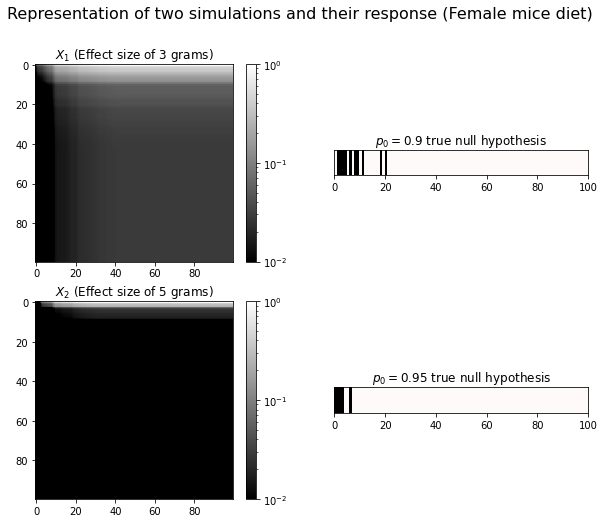

In [ ]:
# Image representantion and distribution of the response

cmap = mpl.colors.ListedColormap(['snow', 'k'])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10,8))

im = ax1.imshow(example_1['X'], cmap='gray', norm= LogNorm(vmin=1e-2, vmax=1))
plt.colorbar(im, ax=ax1)
ax1.set_title(r'$X_1$ (Effect size of 3 grams)')
extent = 0,100,0,1
ax2.imshow(example_1['Y'].reshape(1,100), cmap=cmap, extent = extent)
asp2 = np.diff(ax2.get_xlim())[0] / np.diff(ax2.get_ylim())[0]
ax2.set_aspect(asp2*0.1)
ax2.set(ylabel='')
ax2.set_yticks([])
ax2.set_title(r'$p_0 = 0.9$ true null hypothesis')

im = ax3.imshow(example_2['X'], cmap='gray', norm= LogNorm(vmin=1e-2, vmax=1))
plt.colorbar(im, ax=ax3)
ax3.set_title(r'$X_2$ (Effect size of 5 grams)')
ax4.imshow(example_2['Y'].reshape(1,100), cmap=cmap, extent = extent)
asp4 = np.diff(ax4.get_xlim())[0] / np.diff(ax4.get_ylim())[0]
ax4.set_aspect(asp4*0.1)
ax4.set(ylabel='')
ax4.set_yticks([])
ax4.set_title(r'$p_0 = 0.95$ true null hypothesis')

fig.suptitle('Representation of two simulations and their response (Female mice diet)', fontsize=16)

fig.show()
#fig.savefig('fig3_0_sim3.png')

#from google.colab import files
#files.download("fig3_0_sim3.png")

In [ ]:
# Confusion matrix for Example 1
example_1_CM = MHT_Significant_values(v_grid = np.array([0.05]), 
                                      a_pvalues = example_1['p_value'],
                                      a_nullHypothesis = example_1['Y'],
                                      n_m = 100,
                                      n_sim = 1)

# Confusion Matrix Hypothesis testing without correction
_,fp, tp, fn, tn,_ = example_1_CM['counts_HT'][1]
example_1_CM_HT = {'True': [tn,fp], 'False': [fn,tp]}
pd.DataFrame.from_dict(example_1_CM_HT, orient='index', columns=['Not called significant', 'Significant'])

,Not called significant,Significant
True,87,3
False,3,7


In [ ]:
# Confusion matrix under BH Procedure for example 1
# Confusion Matrix Hypothesis testing without correction
_,fp, tp, fn, tn,_ = example_1_CM['counts_BH'][1]
example_1_CM_HT = {'True': [tn,fp], 'False': [fn,tp]}
pd.DataFrame.from_dict(example_1_CM_HT, orient='index', columns=['Not called significant', 'Significant'])

,Not called significant,Significant
True,90,0
False,10,0


In [ ]:
# AUC (For significance levels 0.05)

example_1_call_HT = np.logical_not(np.where(example_1['p_value']<0.05, False, True)).astype(int)

# Only one class: roc_auc_score is not defined in that case. Assign value 0.5
example_1_call_BH = np.logical_not(np.where(example_1['p_value']<0.0005, False, True)).astype(int)

print('AUROC-MHT = {:.2f}'.format(roc_auc_score(example_1['Y'], example_1_call_HT)))
print('------------------')
print('AUROC-BH = {:.2f}'.format(0.5))
average_precision_ex_1 = average_precision_score(example_1['Y'], example_1_call_BH)
print('Average precision-BH: {0:0.2f}'.format(average_precision_ex_1))

AUROC-MHT = 0.83
------------------
AUROC-BH = 0.50
Average precision-BH: 0.10


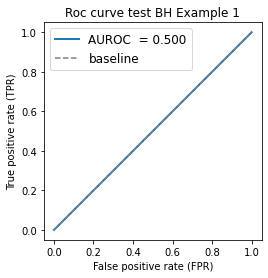

In [ ]:
# Plot the ROC curve:
plot_roc(labels = example_1['Y'].ravel(), predictions = example_1_call_BH, title = 'Roc curve test BH Example 1')

Warning! Usually the AUPRC and the Average Precision are the same. Both value are equal when the second entry correspond to the score/probability of the class. However, we have the predicted class.

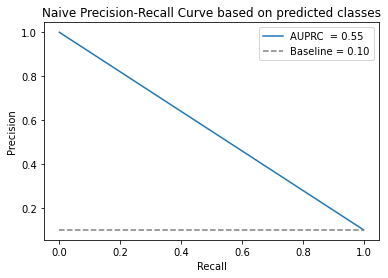

------------
[1. 0.] [0.1 1. ]


In [ ]:
prec, recall, _ = precision_recall_curve(example_1['Y'], example_1_call_BH)
plt.plot(recall, prec, label = 'AUPRC  = {:.2f}'.format(auc(recall,prec)))
plt.plot([0, 1], [0.1, 0.1], linestyle='--', label='Baseline = {:.2f}'.format(0.1), color = 'grey')
plt.title('Naive Precision-Recall Curve based on predicted classes')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

print('------------')
print(recall,prec)

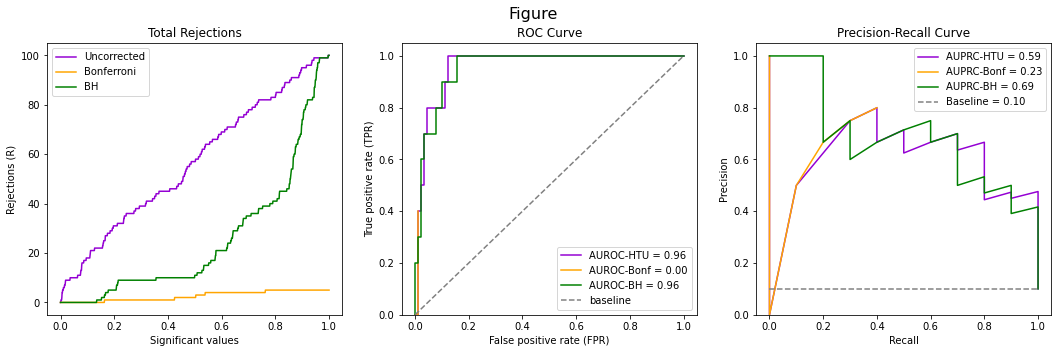

In [ ]:
# Compute the metrics manually using the grid:
grid_significant =  np.arange(0, 1.001, 0.001)
#print('Significance levels :', grid_significant)

# Performance UHT, BFC and BHC
out_example_1 = MHT_Significant_values(v_grid = grid_significant, 
                                            a_pvalues = example_1['p_value'],
                                            a_nullHypothesis = example_1['Y'],
                                            n_m = 100,
                                            n_sim = 1)

baseline_pr = np.sum(example_1['Y'].ravel())/len(example_1['Y'].ravel())
plot_performance_metrics(v_grid = grid_significant,
                     out_sig_grid = out_example_1,
                     baseline_pr = baseline_pr,
                     title = 'Figure')

In [ ]:
# Confusion matrix BH
example_2_CM = MHT_Significant_values(v_grid = np.array([0.05]),
                                      a_pvalues = example_2['p_value'],
                                      a_nullHypothesis = example_2['Y'],
                                      n_m = 100,
                                      n_sim = 1)

# Confusion Matrix Hypothesis testing without correction
_,fp, tp, fn, tn,_ = example_2_CM['counts_BH'][1]
example_2_CM_BH = {'True': [tn,fp], 'False': [fn,tp]}
pd.DataFrame.from_dict(example_2_CM_BH, orient='index', columns=['Not called significant', 'Significant'])

,Not called significant,Significant
True,95,0
False,2,3


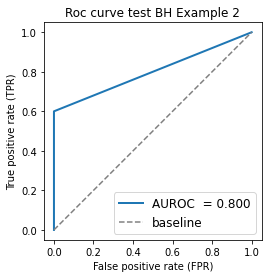

In [ ]:
# ROC curve of Example 2
example_2_call_BH = np.logical_not(np.where(example_2['p_value'] <0.0005, False, True)).astype(int)

plot_roc(labels = example_2['Y'].ravel(), predictions = example_2_call_BH, title = 'Roc curve test BH Example 2')

In [ ]:
print('AUROC-BH = {:.2f}'.format(roc_auc_score(example_2['Y'], example_2_call_BH)))
average_precision_ex_2 = average_precision_score(example_2['Y'], example_2_call_BH)
print('Average precision-BH: {0:0.2f}'.format(average_precision_ex_2))


AUROC-BH = 0.80
Average precision-BH: 0.62


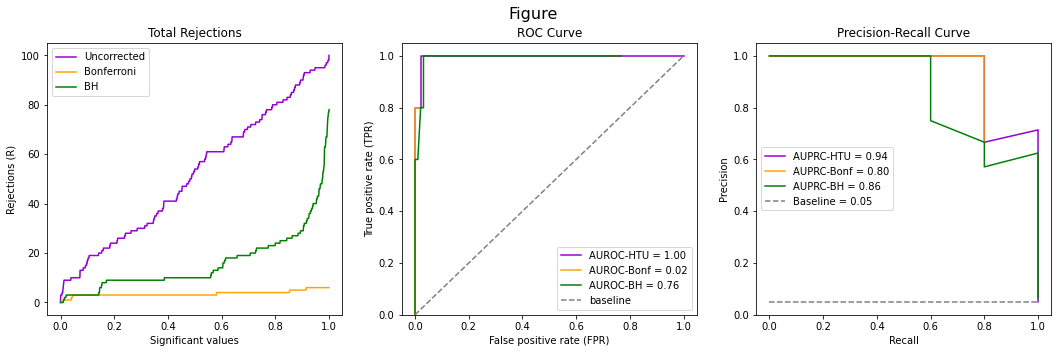

In [ ]:
# Performance UHT, BFC and BHC
out_example_2 = MHT_Significant_values(v_grid = grid_significant, 
                                            a_pvalues = example_2['p_value'],
                                            a_nullHypothesis = example_2['Y'],
                                            n_m = 100,
                                            n_sim = 1)
baseline_pr = np.sum(example_2['Y'].ravel())/len(example_2['Y'].ravel())
plot_performance_metrics(v_grid = grid_significant,
                     out_sig_grid = out_example_2,
                     baseline_pr = baseline_pr,
                     title = 'Figure')

In [ ]:
Y_1_2 = np.array([example_1['Y'], example_2['Y']])
call_1_2 = np.array([example_1_call_BH, example_2_call_BH])
p_value_1_2 = np.array([example_1['p_value'], example_2['p_value']])


print('True values shape: ' , Y_1_2.shape)
print('BH declaration shape: ' , call_1_2.shape)

True values shape:  (2, 100)
BH declaration shape:  (2, 100)


Shape Multilabel CM (2, 2, 2)


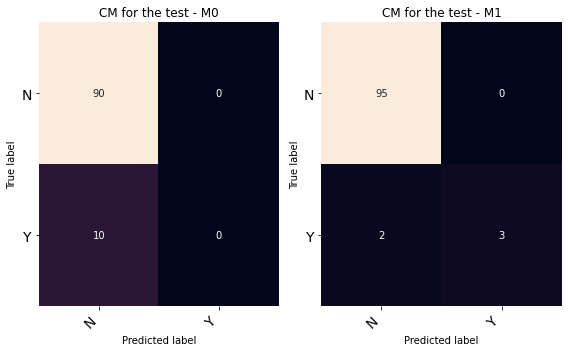

In [ ]:
# Define the multilabel confunsion matrix and print their shape
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns

mcm = multilabel_confusion_matrix(Y_1_2.T, call_1_2.T)
print('Shape Multilabel CM', mcm.shape)

# Defining a list with the label for each level
labels = ["".join("M" + str(i)) for i in range(0, Y_1_2.T.shape[1])]

# Function that Print several Confusion Matrices:
# Source code: https://stackoverflow.com/questions/62722416/plot-confusion-matrix-for-multilabel-classifcation-python

def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("CM for the test - " + class_label)

# Final plot
fig, ax = plt.subplots(1, 2, figsize=(8, 5))
    
for axes, cfs_matrix, label in zip(ax.flatten(), mcm, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

In [ ]:
# Confusion matrix BH for examples 1 and 2.
cm = confusion_matrix(Y_1_2.ravel() ,call_1_2.ravel())
pd.DataFrame(cm, index=['True', 'False'], columns=['Not called significant', 'Significant'])

,Not called significant,Significant
True,185,0
False,12,3


In [ ]:
# Extract the values of the Confusion matrix
TN, FP, FN, TP = cm.flatten()

print('False Positive (FP): V = '  + str(FP))
print('True Positive (TP):  S = '  + str(TP))
print('True Negative (TN):  U = '  + str(TN))
print('False Negative (FN): T = '  + str(FN))
print('-----------------------------')

# Type-I error rate (False Positive Rate, 1 - specificity)
FPR = FP/(FP + TN)
print('False Positive Rate (FPR) = {:.3f}'.format(FPR))

# Type-II error rate (False Negative Rate)
FNR = FN/(FN + TP)
print('False Negative Rate (FNR) = {:.3f}'.format(FNR))

# True Positive Rate (sensitivity, recall power)
TPR = TP/(TP + FN)
print('True  Positive Rate (TPR) = {:.3f}'.format(TPR))

# Positive Predicted value Precision
PPV = TP / (TP + FP)
print('Positive predited value (PPV) = {:.3f}'.format(PPV))

False Positive (FP): V = 0
True Positive (TP):  S = 3
True Negative (TN):  U = 185
False Negative (FN): T = 12
-----------------------------
False Positive Rate (FPR) = 0.000
False Negative Rate (FNR) = 0.800
True  Positive Rate (TPR) = 0.200
Positive predited value (PPV) = 1.000


In [ ]:
# Classification Report
print(classification_report(Y_1_2.ravel() ,call_1_2.ravel()))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       185
           1       1.00      0.20      0.33        15

    accuracy                           0.94       200
   macro avg       0.97      0.60      0.65       200
weighted avg       0.94      0.94      0.92       200



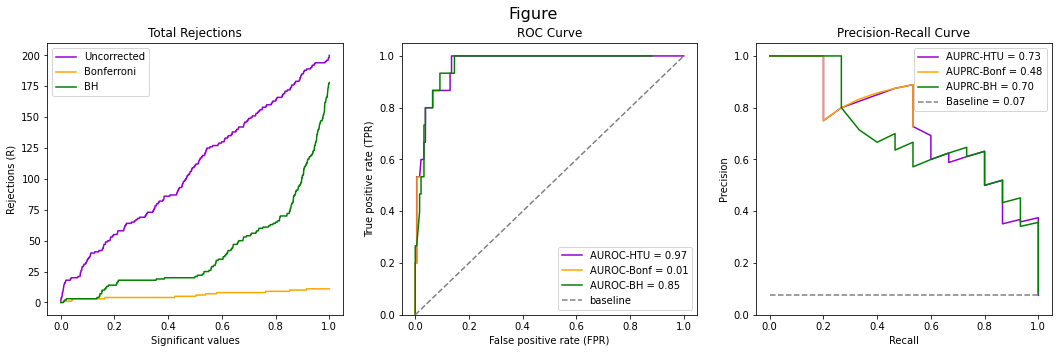

In [ ]:
# Performance UHT, BFC and BHC
out_example_1_2 = MHT_Significant_values(v_grid = grid_significant, 
                                       a_pvalues = p_value_1_2,
                                       a_nullHypothesis = Y_1_2,
                                       n_m = 100,
                                       n_sim = 2)
baseline_pr = np.sum(Y_1_2.ravel())/len(Y_1_2.ravel())
plot_performance_metrics(v_grid = grid_significant,
                     out_sig_grid = out_example_1_2,
                     baseline_pr = baseline_pr,
                     title = 'Figure')

In [ ]:
print(average_precision_score(Y_1_2.T, call_1_2.T, average='macro'))
print(average_precision_score(Y_1_2.T, call_1_2.T, average='micro'))

0.36
0.26


In [ ]:
# Macro metrics are equivalent to the mean of the AUROC and Average precision

# AUROC:
AUROC_macro = roc_auc_score(Y_1_2.T, call_1_2.T, average='macro')
print('AUROC-macro: ', AUROC_macro)
print('--------------------------')
# Average precision:
Avg_Prec_macro = average_precision_score(Y_1_2.T, call_1_2.T, average='macro')
print('Avg_Prec-macro: ',Avg_Prec_macro)

AUROC-macro:  0.65
--------------------------
Avg_Prec-macro:  0.36


In [ ]:
# AUC Micro
AUROC_micro = roc_auc_score(Y_1_2, call_1_2, average='micro')
print('AUROC-micro: ',AUROC_micro)

# Average precision:
Avg_Prec_micro = average_precision_score(Y_1_2.T, call_1_2.T, average='micro')
print('Avg_Prec-micro: ',Avg_Prec_micro)
print('--------------------------')


# Same result if we flatten into 1D:
print('AUROC- flatten vector:', roc_auc_score(Y_1_2.ravel(), call_1_2.ravel()))
print('Avg_Prec- flatten vector:', average_precision_score(Y_1_2.ravel(), call_1_2.ravel()))

AUROC-micro:  0.6
Avg_Prec-micro:  0.26
--------------------------
AUROC- flatten vector: 0.6
Avg_Prec- flatten vector: 0.26


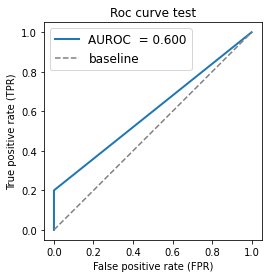

In [ ]:
plot_roc(Y_1_2.ravel(), call_1_2.ravel(), title = 'Roc curve test')

In [ ]:
# Computing the AUPRC and AUROC using Keras

m_AUPRC = tf.keras.metrics.AUC(curve='PR')
m_AUROC = tf.keras.metrics.AUC()


In [ ]:
# Computing the Recall using Keras

m_AUPRC.update_state(Y_1_2, call_1_2)

#  Print: Recall Keras
m_AUPRC.result().numpy()

0.29677832

In [ ]:
m_AUROC.update_state(Y_1_2, call_1_2) 

# Print AUC-micro
m_AUROC.result().numpy()

0.6

In [ ]:
m_AUPRC_Multi_label = tf.keras.metrics.AUC(curve = 'PR', multi_label=True, num_labels=2)
m_AUPRC_Multi_label.update_state(Y_1_2.T,call_1_2.T) 

m_AUROC_Multi_label = tf.keras.metrics.AUC(multi_label=True, num_labels=2)
m_AUROC_Multi_label.update_state(Y_1_2.T,call_1_2.T) 

# Print AUC-macro
print(m_AUPRC_Multi_label.result().numpy())
print(m_AUROC_Multi_label.result().numpy())

0.37536657
0.65


### General example:

In [13]:
# Simulation parameters

_m =  100  # Number of test
_N = 12    # Sample Size

print('Number of test:', _m)
print('Sample Size:', _N)

Number of test: 100
Sample Size: 12


In [14]:
# Effect size
min_delta = 0.5   # Min Effect size
max_delta = 10.1  # Max effect size

vec_delta = np.arange(start = min_delta, stop = max_delta, step = 0.1)
print('Number of ES:', len(vec_delta))
print(vec_delta)
print('----------------------------')

## Proportion of (true) null hypothesis
vec_prop = np.arange(0.9, 1, 0.01)
print('Number of Proportion H0:', len(vec_prop))
print('Proportion Null Hypothesis true:', vec_prop)

Number of ES: 96
[ 0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8
  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7  2.8  2.9  3.   3.1  3.2
  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1  4.2  4.3  4.4  4.5  4.6
  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5  5.6  5.7  5.8  5.9  6.
  6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9  7.   7.1  7.2  7.3  7.4
  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3  8.4  8.5  8.6  8.7  8.8
  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7  9.8  9.9 10. ]
----------------------------
Number of Proportion H0: 10
Proportion Null Hypothesis true: [0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99]


In [15]:
# We simulate 96 for each Effect size (delta) and 10 different null (true) hypothesis
_image_lbbf = [femaleMiceWeightSimulation(N = _N, m = _m, p0 = _prop, delta = _delta) 
               for _delta in vec_delta 
               for _prop in vec_prop]

# Number of simulations:
n_sim = len(_image_lbbf)
print('Number of simulations:' , n_sim)

Number of simulations: 960


In [16]:
# Extracting the image as X
X = np.array([_image_lbbf[index]['X'] for index in range(0, n_sim)])
print('X shape:', X.shape)

# Extracting the response (Y)
Y = np.array([_image_lbbf[index]['Y'] for index in range(0, n_sim)])
print('Y shape:', Y.shape)

# Extracting the p-values ()
p_values = np.array([_image_lbbf[index]['p_value'] for index in range(0, n_sim)])
print('P-values shape:', p_values.shape)

Effect_sizes = np.array([_image_lbbf[index]['ES'] for index in range(0, n_sim)])
print('Effect sizes shape:', Effect_sizes.shape)

Prop_H0 = np.array([_image_lbbf[index]['Prop_H0'] for index in range(0, n_sim)])
print('Prop H0 shape:', Prop_H0.shape)

X shape: (960, 100, 100)
Y shape: (960, 100)
P-values shape: (960, 100)
Effect sizes shape: (960,)
Prop H0 shape: (960,)


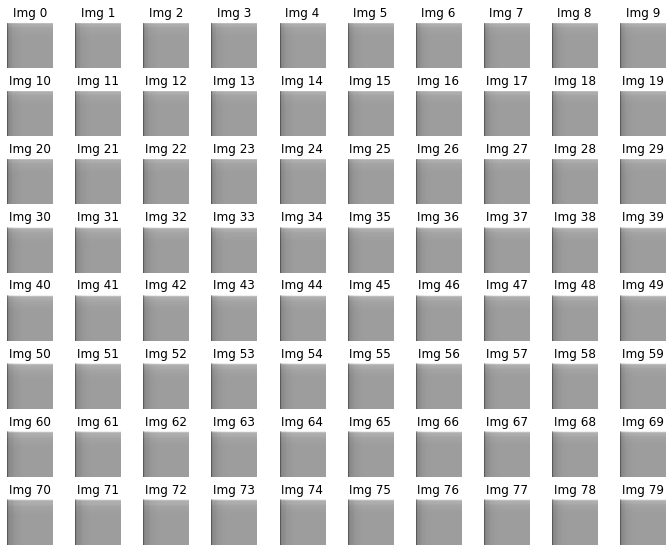

In [17]:
# Plot of the first 40 matrices
n_rows = 8
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X[index], cmap='gray', norm= LogNorm(vmin=1e-4, vmax=1))
        plt.axis('off')
        plt.title('Img ' + str(index), fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
#save_fig('LBBF_sim1_plot', tight_layout=False)
plt.show()

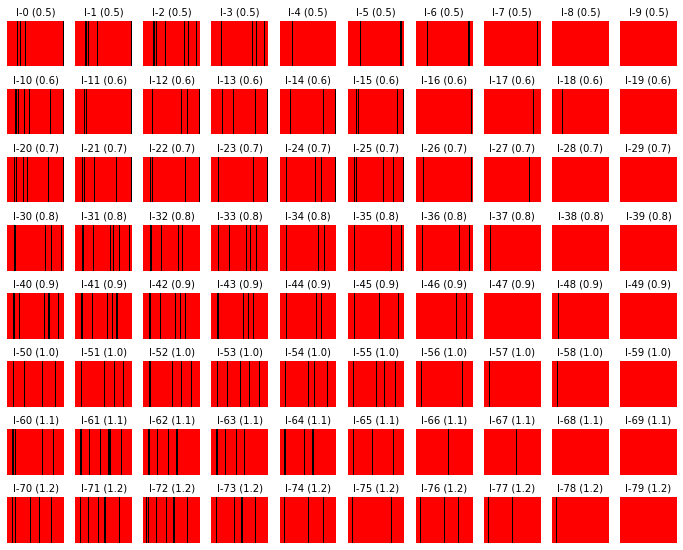

In [18]:
# Plot of the first 40 matrices
n_rows = 8
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
cmap = mpl.colors.ListedColormap(['r', 'k'])
effects_size = np.round(np.repeat(vec_delta, len(vec_prop), axis=0),2)
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        v2_Y= np.empty([2, _m])
        v2_Y[:,:] = Y[index]
        plt.contourf(v2_Y, cmap=cmap)
        plt.axis('off')
        plt.title('I-' + str(index) + ' (' + str(effects_size[index]) + ')', fontsize=10)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
#save_fig('Resp_sim1_plot', tight_layout=False)
plt.show()

In [19]:
# Vector of indices (for extractinf the p-values associated with the testing set)
indices = np.arange(n_sim)

# Train and test
X_train_full, X_test, y_train_full, y_test, idx_train_full, idx_test = train_test_split(X, Y, indices ,random_state = 42, test_size = 0.2)

# Train and validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state = 42, test_size = 0.1)

# Dimensions
print('X_train shape:', X_train.shape)
print('X_valid shape:', X_valid.shape)
print('X_test shape:', X_test.shape)

X_train shape: (691, 100, 100)
X_valid shape: (77, 100, 100)
X_test shape: (192, 100, 100)


In [20]:
# Extracting the p-values of test set
pvalues_test = p_values[idx_test]

# Distribution of Proportion H0 train and test
Prop_H0_test = Prop_H0[idx_test]
Prop_H0_train_full = Prop_H0[idx_train_full]

# Distribution of Effect size train and test
Effect_sizes_train_full = Effect_sizes[idx_train_full]
Effect_sizes_test = Effect_sizes[idx_test]

In [21]:
unique, counts = np.unique(y_train_full.ravel(), return_counts=True)
pd.DataFrame.from_dict(dict(zip(unique, counts)), orient='index', columns=['Quantity'])

,Quantity
0,72876
1,3924


In [22]:
unique, counts = np.unique(y_test.ravel(), return_counts=True)
pd.DataFrame.from_dict(dict(zip(unique, counts)), orient='index', columns=['Quantity'])

,Quantity
0,18228
1,972


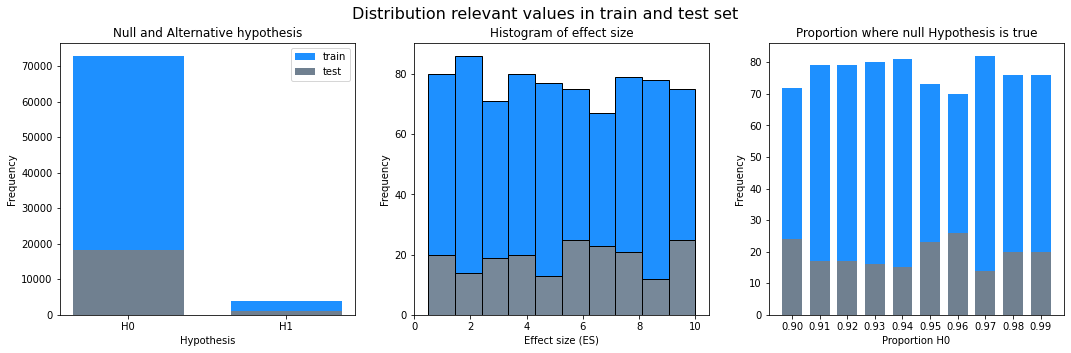

In [23]:
# Distribution of relevant parameters between training and testing set 

plot_relevant_parameters_train_test(y_train = y_train_full,
                                    y_test = y_test,
                                    Effect_sizes_train_full = Effect_sizes_train_full,
                                    Effect_sizes_test = Effect_sizes_test,
                                    Prop_H0_train_full = Prop_H0_train_full,
                                    Prop_H0_test = Prop_H0_test,
                                    v_propH0 = vec_prop,
                                    fig_save = 'fig3_1_train_test.png')


## ANN

In [24]:
# Refresh: Number of (null) hypothesis test
print('Total Null hypothesis:', _m)
print('--------------------------')

# Multilabel classification: Define the number of elements of input/output in the NN
# same as (_m)

INPUT_SHAPE_ANN  = [_m, _m]
OUT_CLASSES_ANN = _m

# print
print('Input: Dimension image LBBF: ', INPUT_SHAPE_ANN)
print('Output: Number of labels', OUT_CLASSES_ANN)

Total Null hypothesis: 100
--------------------------
Input: Dimension image LBBF:  [100, 100]
Output: Number of labels 100


In [25]:
# Define a simple sequential model
def create_ANN_model(INPUT_SHAPE,
                     OUT_CLASSES,
                     INITIALIZER,
                     NEURONS_1, NEURONS_2,
                     DROPOUT,
                     LOSS_FN,
                     OPTIMIZER,
                     METRICS,
                     SEED = 42):

  # 0)
  keras.backend.clear_session()

  # 1) Set seed
  np.random.seed(SEED)
  tf.random.set_seed(SEED)

  # 2) Sequential model
  model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = INPUT_SHAPE),
    keras.layers.Dense(NEURONS_1, 
                       kernel_initializer = INITIALIZER,
                       activation = "relu"),
    keras.layers.Dense(NEURONS_2, 
                       kernel_initializer = INITIALIZER,
                       activation = "relu"),
    keras.layers.Dropout(DROPOUT),
    keras.layers.Dense(OUT_CLASSES, 
                       activation = "sigmoid")
  ])

  #2) compile method
  model.compile(loss      = LOSS_FN,
                optimizer = OPTIMIZER,
                metrics   = METRICS)
  
  return model

In [26]:
# 2) Hyperparameters:

## 2.1) Number of neurons by (hidden) layer
NEURONS_1 = 500  # 5% of the total pixels
NEURONS_2 = 250  # 2.5% of the total pixels
DROPOUT = 0.5

## 2.2) Initial weight
INITIALIZER = keras.initializers.HeUniform()

# 3)  compilationHyperparameters
LOSS_FN   = keras.losses.binary_crossentropy
OPTIMIZER = keras.optimizers.Nadam()
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='AUROC'),
      keras.metrics.AUC(name='AUPRC', curve='PR'), # precision-recall curve
]

# Create the model instance
model_ANN = create_ANN_model(INPUT_SHAPE_ANN,
                     OUT_CLASSES_ANN,
                     INITIALIZER,
                     NEURONS_1, NEURONS_2,
                     DROPOUT,
                     LOSS_FN,
                     OPTIMIZER,
                     METRICS)

# Print Model summary (model's architecture)
model_ANN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 500)               5000500   
_________________________________________________________________
dense_1 (Dense)              (None, 250)               125250    
_________________________________________________________________
dropout (Dropout)            (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               25100     
Total params: 5,150,850
Trainable params: 5,150,850
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Set the correct initial bias
eval_ANN_train = model_ANN.evaluate(X_train, y_train, verbose=0)

# Print loss: Correct if loss is greater > 1
print('Train loss = {:.3f}'.format(eval_ANN_train[0]))
print('-----------------------')
print('Example predictions:')
model_ANN.predict(X_train[0:1,:,:])

Train loss = 0.688
-----------------------
Example predictions:


array([[0.5021051 , 0.48347363, 0.46563843, 0.5358418 , 0.5238869 ,
        0.4994356 , 0.5026058 , 0.4868604 , 0.5539299 , 0.4379087 ,
        0.5221931 , 0.49186075, 0.5356144 , 0.46604156, 0.5153413 ,
        0.49232185, 0.5377573 , 0.4590201 , 0.47795254, 0.5403122 ,
        0.4380155 , 0.5116375 , 0.52560437, 0.4608717 , 0.47595915,
        0.5826372 , 0.5079687 , 0.42985082, 0.50651366, 0.4696369 ,
        0.5264076 , 0.5053584 , 0.46444744, 0.5552475 , 0.5039352 ,
        0.48027366, 0.43960124, 0.48667815, 0.52615887, 0.48498648,
        0.47994357, 0.48020697, 0.4852022 , 0.45798135, 0.5235425 ,
        0.520306  , 0.4723915 , 0.47177437, 0.5125195 , 0.53351855,
        0.5182304 , 0.4950754 , 0.49244645, 0.48829708, 0.547345  ,
        0.48474348, 0.47347796, 0.46616706, 0.48901114, 0.42056763,
        0.42686966, 0.51092446, 0.4412899 , 0.50331694, 0.47931707,
        0.53783196, 0.56720364, 0.49781016, 0.4734149 , 0.53952044,
        0.39146537, 0.55655855, 0.5099254 , 0.55

In [28]:
# Model Train

# 1) Hypeparameters
EPOCHS = 50

# Early_stopping (avoid overfitting)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_AUPRC', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

# 2) fit method

start_time = time.time()

history_ANN = model_ANN.fit(X_train, 
                        y_train, 
                        epochs = EPOCHS,
                        validation_data = (X_valid, y_valid),
                        callbacks=[early_stopping],
                        verbose=0)

print('Elapsed time (seconds) = {:.3f}'.format(time.time() - start_time))

Elapsed time (seconds) = 99.539


In [29]:
eval_ANN_train = model_ANN.evaluate(X_train, y_train, verbose=0)

# Print loss and metrics evaluation train set
print('Train loss = {:.3f}'.format(eval_ANN_train[0]))
print('-----------------------')
print('Train Accuracy  = {:.3f}'.format(eval_ANN_train[5]))
print('Train Precision = {:.3f}'.format(eval_ANN_train[6]))
print('Train Recall    = {:.3f}'.format(eval_ANN_train[7]))
print('Train AUROC     = {:.3f}'.format(eval_ANN_train[8]))
print('Train AUPRC     = {:.3f}'.format(eval_ANN_train[9]))

Train loss = 0.049
-----------------------
Train Accuracy  = 0.984
Train Precision = 0.915
Train Recall    = 0.748
Train AUROC     = 0.987
Train AUPRC     = 0.893


In [30]:
eval_ANN_test = model_ANN.evaluate(X_test, y_test, verbose = 0)

# Print loss and metrics evaluation test set
print('Test loss = {:.3f}'.format(eval_ANN_test[0]))
print('-----------------------')
print('Test Accuracy  = {:.3f}'.format(eval_ANN_test[5]))
print('Test Precision = {:.3f}'.format(eval_ANN_test[6]))
print('Test Recall    = {:.3f}'.format(eval_ANN_test[7]))
print('Test AUROC     = {:.3f}'.format(eval_ANN_test[8]))
print('Test AUPRC     = {:.3f}'.format(eval_ANN_test[9]))

Test loss = 0.048
-----------------------
Test Accuracy  = 0.985
Test Precision = 0.904
Test Recall    = 0.787
Test AUROC     = 0.984
Test AUPRC     = 0.900


In [31]:
# Parameters  history_ANN
print(history_ANN.params)
print('----------------')
print('Evaluated Epochs: ', len(history_ANN.epoch))

{'verbose': 0, 'epochs': 50, 'steps': 22}
----------------
Evaluated Epochs:  50


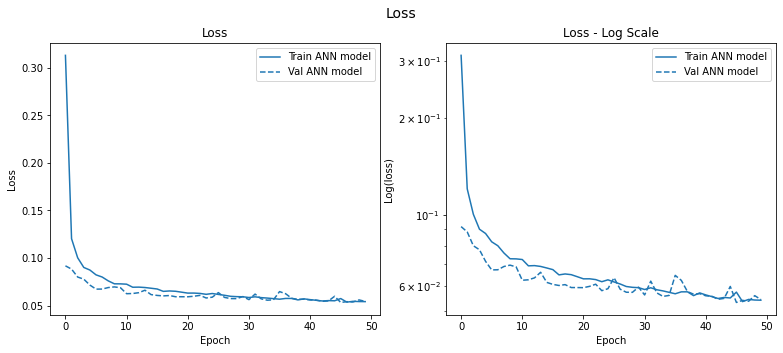

In [32]:
plot_DL_log_loss(history = history_ANN, label = 'ANN model', n = 0, title = 'Loss')

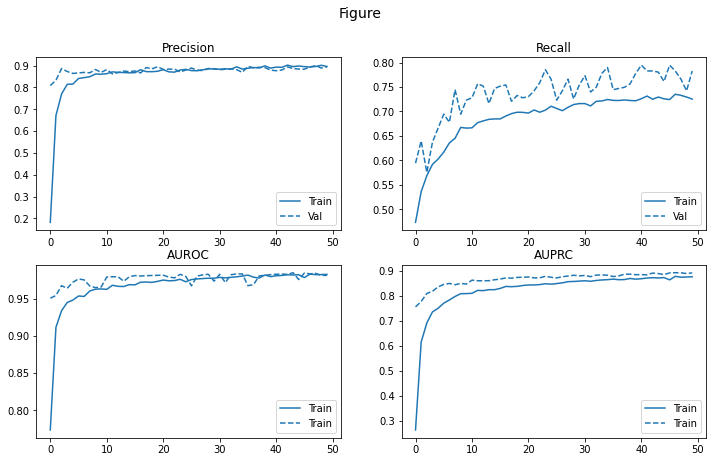

In [33]:
plot_DL_performance_metrics(history_ANN)

### Test set performance

y_score shape: (192, 100)


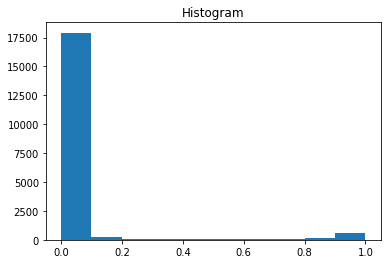

In [34]:
# Model predictions
y_score_ANN = model_ANN.predict(X_test)
print('y_score shape:', y_score_ANN.shape)

mpl.rcParams['figure.figsize'] = (6, 4)
plt.hist(y_score_ANN.ravel())
plt.title('Histogram')
plt.show()

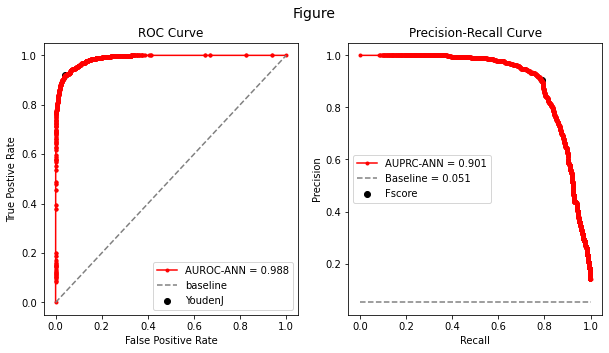

In [35]:
# calculate ROC and Precision-Recall curves
stats_ANN = plot_ROC_PRC_score(y_test = y_test,
                           y_score = y_score_ANN,
                           plot = True,
                           type_DL = 'ANN')

In [36]:
# AP and AUPRC are the same (Given that we use the score of the class)
print('Average precision-recall score: {0:0.3f}'.format(
      stats_ANN['avg_prec']))

Average precision-recall score: 0.901


In [37]:
Youden_Stat = stats_ANN['Youden_Stat']
print('Youdens J Statitic = %.3f' % (Youden_Stat))
print('Confusion matrix:')

# Prediction labels: Based on Youden
y_hat_ANN = np.where(y_score_ANN >= Youden_Stat, 1,0)

# Confusion matix and pandas display
cm_test_ANN = confusion_matrix(y_test.ravel() ,y_hat_ANN.ravel())
pd.DataFrame(cm_test_ANN, index=['True', 'False'], columns=['Not called significant', 'Significant'])

Youdens J Statitic = 0.051
Confusion matrix:


,Not called significant,Significant
True,17477,751
False,79,893


In [38]:
thresholds_PR = stats_ANN['thresholds_PR_Stat']
fscore = stats_ANN['fscore']
print('Best Threshold=%.3f, F-Score=%.3f' % (thresholds_PR, fscore))
print('Confusion matrix:')

# Prediction labels: Based on Youden
y_hat_ANN = np.where(y_score_ANN >= thresholds_PR, 1,0)

# Confusion matix and pandas display
cm_test_ANN = confusion_matrix(y_test.ravel() ,y_hat_ANN.ravel())
pd.DataFrame(cm_test_ANN, index=['True', 'False'], columns=['Not called significant', 'Significant'])

Best Threshold=0.498, F-Score=0.842
Confusion matrix:


,Not called significant,Significant
True,18146,82
False,205,767


In [39]:
tt = 0.05
thresholds_ROC = stats_ANN['thresholds_ROC']
fpr_ANN = stats_ANN['fpr_NN']
max_thr_fpr = thresholds_ROC[len(fpr_ANN[fpr_ANN <= tt]) - 1]
print('Threshold with FPR 0.05 = %.3f' % (np.round(max_thr_fpr,3)))
print('Confusion matrix:')
# Prediction labels
y_hat_ANN = np.where(y_score_ANN >= max_thr_fpr, 1,0)

# Confusion matix and pandas display
cm_test_ANN = confusion_matrix(y_test.ravel() ,y_hat_ANN.ravel())
pd.DataFrame(cm_test_ANN, index=['True', 'False'], columns=['Not called significant', 'Significant'])

Threshold with FPR 0.05 = 0.042
Confusion matrix:


,Not called significant,Significant
True,17329,899
False,75,897


In [40]:
tt = 0.0
max_thr_fpr = thresholds_ROC[len(fpr_ANN[fpr_ANN <= tt]) - 1]
print('Threshold with FPR 0 = %.3f' % (np.round(max_thr_fpr,3)))
print('Confusion matrix:')
# Prediction labels
y_hat_ANN = np.where(y_score_ANN >= max_thr_fpr, 1,0)

# Confusion matix and pandas display
cm_test_ANN = confusion_matrix(y_test.ravel() ,y_hat_ANN.ravel())
pd.DataFrame(cm_test_ANN, index=['True', 'False'], columns=['Not called significant', 'Significant'])

Threshold with FPR 0 = 0.993
Confusion matrix:


,Not called significant,Significant
True,18228,0
False,606,366


### Test set: Comparison of models

#### Significance space

In [41]:
# Compute the metrics manually using the grid:
grid_significant = np.array([0.0001, 0.001, 0.005, 0.01, 0.025, 0.05, 0.1,0.2, 0.3])
print('Significance levels :', grid_significant)

Significance levels : [1.0e-04 1.0e-03 5.0e-03 1.0e-02 2.5e-02 5.0e-02 1.0e-01 2.0e-01 3.0e-01]


In [42]:
n_sim_test = y_test.shape[0]
# Performance UHT, BFC and BHC
out_test_trad = MHT_Significant_values(v_grid = grid_significant, 
                                            a_pvalues = pvalues_test,
                                            a_nullHypothesis = y_test,
                                            n_m = _m,
                                            n_sim = n_sim_test)

# Performance ANN for several significant values
out_test_DL_ANN = DL_Significant_values(v_grid = grid_significant, 
                                      a_test = y_test,     
                                      a_score = y_score_ANN)
									  
									  
sig_report_ANN = significance_report(out_trad = out_test_trad,
                                     out_ANN = out_test_DL_ANN)

# Total Rejections:
pd.options.display.float_format = "{:.4f}".format                                     
pd.DataFrame.from_dict(sig_report_ANN['data_rejections'], orient='index', columns= np.append(0,grid_significant))

,0.0000,0.0001,0.0010,0.0050,0.0100,0.0250,0.0500,0.1000,0.2000,0.3000
Uncorrected,0,372,518,827,877,1313,1363,2767,4923,6553
Bonferroni,0,104,226,331,372,434,475,518,760,785
BH,0,152,297,413,457,562,650,758,1019,1139
ANN,0,384,643,858,982,1315,1796,2753,4608,6433


In [43]:
# Type-I errors
pd.options.display.float_format = "{:.2f}".format
pd.DataFrame.from_dict(sig_report_ANN['data_typeI_error'], orient='index', columns= np.append(0,grid_significant))

,0.00,0.00,0.00,0.01,0.01,0.03,0.05,0.10,0.20,0.30
Uncorrected,0,0.00,0.00,0.01,0.01,0.03,0.03,0.11,0.22,0.31
Bonferroni,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01
BH,0,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.02,0.02
ANN,0,0.00,0.00,0.00,0.01,0.02,0.05,0.10,0.20,0.30


In [44]:
# Type-II errors
pd.DataFrame.from_dict(sig_report_ANN['data_typeII_error'], orient='index', columns= np.append(0,grid_significant))

,0.00,0.00,0.00,0.01,0.01,0.03,0.05,0.10,0.20,0.30
Uncorrected,1,0.62,0.47,0.35,0.30,0.24,0.19,0.13,0.08,0.07
Bonferroni,1,0.89,0.77,0.66,0.62,0.55,0.51,0.47,0.42,0.39
BH,1,0.84,0.69,0.58,0.53,0.47,0.42,0.36,0.30,0.26
ANN,1,0.61,0.36,0.21,0.18,0.11,0.08,0.04,0.01,0.00


#### Complete space

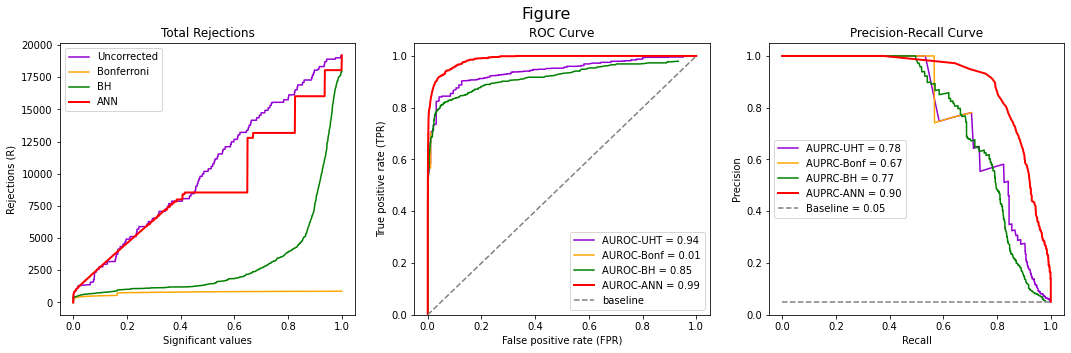

In [45]:
# Compute the metrics manually using the grid:
grid_significant =  np.arange(0, 1.001, 0.001)

# Performance UHT, BFC and BHC
n_sim_test = y_test.shape[0]
out_test_trad = MHT_Significant_values(v_grid = grid_significant, 
                                            a_pvalues = pvalues_test,
                                            a_nullHypothesis = y_test,
                                            n_m = _m,
                                            n_sim = n_sim_test)

# Performance ANN for several significant values
out_test_DL_ANN = DL_Significant_values(v_grid = grid_significant, 
                                      a_test = y_test,     
                                      a_score = y_score_ANN)

# Plot function
baseline_pr = np.sum(y_test.ravel())/len(y_test.ravel())
plot_performance_metrics(v_grid = grid_significant,
                 out_sig_grid = out_test_trad,
                 baseline_pr = baseline_pr,
                 title = 'Figure', 
                 out_ANN = out_test_DL_ANN)

## CNN

In [46]:
# Checking the dimension in train sets
print(X_train.shape)
print(y_train.shape)

(691, 100, 100)
(691, 100)


In [47]:
# Resize the inputs (X_train, X_val, X_test) adding the channel

# No. of channels = 1 (gray scale)

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

## Print dimensions for inputs
print('X_train shape:', X_train.shape)
print('X_valid shape:', X_valid.shape)
print('X_test shape: ', X_test.shape)

X_train shape: (691, 100, 100, 1)
X_valid shape: (77, 100, 100, 1)
X_test shape:  (192, 100, 100, 1)


In [48]:
# Refresh: Number of (null) hypothesis test
print('Total Null hypothesis:', _m)
print('--------------------------')

# Multilabel classification: Define the number of elements of input/output in the NN
# same as (_m)

CHANNELS = 1
INPUT_SHAPE  = [_m, _m, CHANNELS]
OUT_CLASSES = _m

# print
print('Input: Dimension image LBBF: ', INPUT_SHAPE)
print('Output: Number of labels', OUT_CLASSES)

Total Null hypothesis: 100
--------------------------
Input: Dimension image LBBF:  [100, 100, 1]
Output: Number of labels 100


In [49]:
# Define a simple sequential model
def create_CNN_model(INPUT_SHAPE,
                     OUT_CLASSES,
                     INITIALIZER,
                     NEURONS_1, NEURONS_2,
                     DROPOUT,
                     LOSS_FN,
                     OPTIMIZER,
                     METRICS,
                     SEED = 42):

  # 0)
  keras.backend.clear_session()

  # 1) Set seed
  np.random.seed(SEED)
  tf.random.set_seed(SEED)

  # 2) Sequential model
  model = keras.models.Sequential([
    keras.layers.Conv2D(filters = 2, 
                        kernel_size = 3, 
                        padding = "same", 
                        activation = "relu",
                        kernel_initializer = INITIALIZER,
                        input_shape = INPUT_SHAPE),
    keras.layers.MaxPooling2D(pool_size=(2, 2), 
                              strides=(2,2), 
                              padding='same'),
    keras.layers.Flatten(),
    keras.layers.Dense(NEURONS_1, activation="relu", kernel_initializer=INITIALIZER),
    keras.layers.Dense(NEURONS_2, activation="relu", kernel_initializer=INITIALIZER),
    keras.layers.Dropout(DROPOUT),
    keras.layers.Dense(OUT_CLASSES, activation="sigmoid")
  ])

  #2) compile method
  model.compile(loss      = LOSS_FN,
                optimizer = OPTIMIZER,
                metrics   = METRICS)
  
  return model

In [50]:
# 2) Hyperparameters:

## 2.1) Number of neurons by (hidden) layer
NEURONS_1 = 500   # of the total pixels
NEURONS_2 = 250   #  of the total pixels
DROPOUT = 0.5

## 2.2) Initial weight
INITIALIZER = keras.initializers.HeUniform()

# 3)  compilationHyperparameters
LOSS_FN   = keras.losses.binary_crossentropy
OPTIMIZER = keras.optimizers.Nadam()
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='AUROC'),
      keras.metrics.AUC(name='AUPRC', curve='PR'), # precision-recall curve
]

# Create the model instance
model_CNN = create_CNN_model(INPUT_SHAPE,
                     OUT_CLASSES,
                     INITIALIZER,
                     NEURONS_1, NEURONS_2,
                     DROPOUT,
                     LOSS_FN,
                     OPTIMIZER,
                     METRICS)

# Print Model summary (model's architecture)
model_CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 2)       20        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 2)         0         
_________________________________________________________________
flatten (Flatten)            (None, 5000)              0         
_________________________________________________________________
dense (Dense)                (None, 500)               2500500   
_________________________________________________________________
dense_1 (Dense)              (None, 250)               125250    
_________________________________________________________________
dropout (Dropout)            (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               2

In [51]:
# Set the correct initial bias
eval_CNN_train = model_CNN.evaluate(X_train, y_train, verbose=0)

# Print loss: Correct if loss is greater > 1
print('Train loss = {:.3f}'.format(eval_CNN_train[0]))
print('-----------------------')
print('Example predictions:')
model_CNN.predict(X_train[0:1,])

Train loss = 0.699
-----------------------
Example predictions:


array([[0.49602863, 0.5714927 , 0.5145844 , 0.4512657 , 0.4709567 ,
        0.4769376 , 0.5372999 , 0.525567  , 0.4917464 , 0.48060668,
        0.4726019 , 0.4962389 , 0.5000898 , 0.5212562 , 0.5440074 ,
        0.53127694, 0.4533132 , 0.5108197 , 0.48233658, 0.53186435,
        0.56151545, 0.50881153, 0.52817553, 0.536093  , 0.545398  ,
        0.45396024, 0.5226324 , 0.44848612, 0.47461733, 0.49989146,
        0.4395272 , 0.483629  , 0.5064636 , 0.47424018, 0.5120584 ,
        0.49294975, 0.56288266, 0.48821875, 0.46269345, 0.50049096,
        0.5529943 , 0.49171105, 0.5049695 , 0.51884484, 0.5196371 ,
        0.52385664, 0.5272405 , 0.46179208, 0.49730822, 0.58179533,
        0.48811233, 0.50235033, 0.49159393, 0.4968436 , 0.44842392,
        0.51449686, 0.49360627, 0.54719126, 0.49925724, 0.4839208 ,
        0.53473264, 0.48738354, 0.49095625, 0.47818568, 0.51102865,
        0.5217688 , 0.42613822, 0.48690498, 0.4702603 , 0.5099079 ,
        0.49963468, 0.5191589 , 0.5446495 , 0.51

In [52]:
# Model Train

# 1) Hypeparameters
EPOCHS = 50

# Early_stopping (avoid overfitting)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_AUPRC', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

# 2) fit method

start_time = time.time()

history_CNN = model_CNN.fit(X_train, 
                            y_train, 
                            epochs = EPOCHS,
                            validation_data = (X_valid, y_valid),
                            callbacks=[early_stopping],
                            verbose=0)
print('Elapsed time (seconds) = {:.3f}'.format(time.time() - start_time))

Elapsed time (seconds) = 130.243


In [53]:
eval_CNN_train = model_CNN.evaluate(X_train, y_train, verbose=0)

# Print loss and metrics evaluation train set
print('Train loss = {:.3f}'.format(eval_CNN_train[0]))
print('-----------------------')
print('Train Accuracy  = {:.3f}'.format(eval_CNN_train[5]))
print('Train Precision = {:.3f}'.format(eval_CNN_train[6]))
print('Train Recall    = {:.3f}'.format(eval_CNN_train[7]))
print('Train AUROC     = {:.3f}'.format(eval_CNN_train[8]))
print('Train AUPRC     = {:.3f}'.format(eval_CNN_train[9]))

Train loss = 0.051
-----------------------
Train Accuracy  = 0.983
Train Precision = 0.901
Train Recall    = 0.747
Train AUROC     = 0.987
Train AUPRC     = 0.888


In [54]:
eval_CNN_test = model_CNN.evaluate(X_test, y_test, verbose = 0)

# Print loss and metrics evaluation test set
print('Test loss = {:.3f}'.format(eval_CNN_test[0]))
print('-----------------------')
print('Test Accuracy  = {:.3f}'.format(eval_CNN_test[5]))
print('Test Precision = {:.3f}'.format(eval_CNN_test[6]))
print('Test Recall    = {:.3f}'.format(eval_CNN_test[7]))
print('Test AUROC     = {:.3f}'.format(eval_CNN_test[8]))
print('Test AUPRC     = {:.3f}'.format(eval_CNN_test[9]))

Test loss = 0.049
-----------------------
Test Accuracy  = 0.984
Test Precision = 0.883
Test Recall    = 0.780
Test AUROC     = 0.985
Test AUPRC     = 0.895


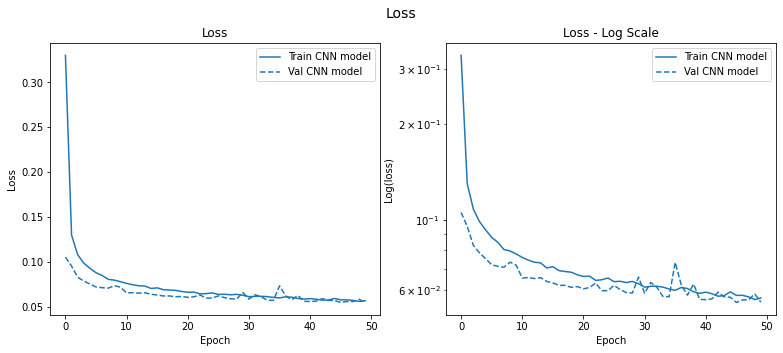

In [55]:
plot_DL_log_loss(history = history_CNN, label = 'CNN model', n = 0, title = 'Loss')

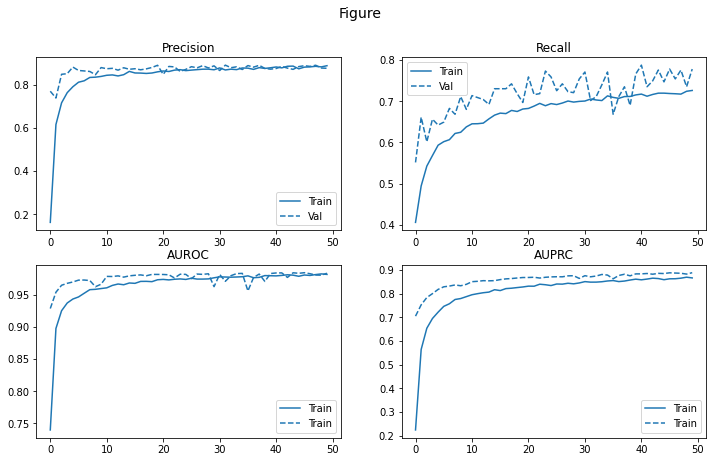

In [56]:
# Metrics Plots
plot_DL_performance_metrics(history_CNN)

### Test set: CNN model

In [57]:
# Model predictions
y_score_CNN = model_CNN.predict(X_test)
print('y_score shape:', y_score_CNN.shape)

y_score shape: (192, 100)


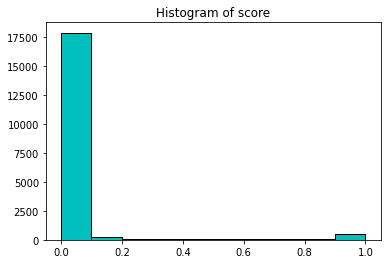

In [58]:
plt.hist(y_score_CNN.ravel(), color='c', edgecolor='k')
plt.title('Histogram of score')
plt.show()

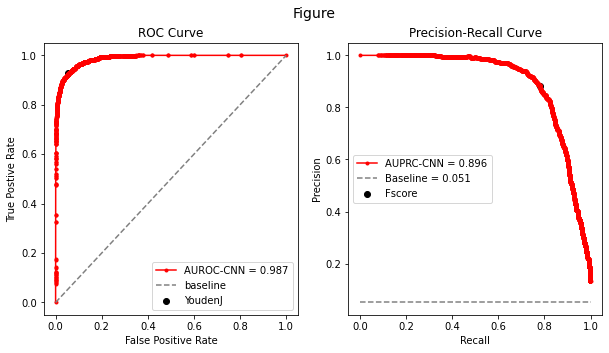

In [59]:
# calculate ROC and Precision-Recall curves
stats_CNN = plot_ROC_PRC_score(y_test = y_test,
                           y_score = y_score_CNN,
                           plot = True,
                           type_DL = 'CNN')

In [60]:
Youden_Stat = stats_CNN['Youden_Stat']
print('Youdens J Statitic = %.3f' % (Youden_Stat))
print('Confusion matrix:')

# Prediction labels: Based on Youden
y_hat_CNN = np.where(y_score_CNN >= Youden_Stat, 1,0)

# Confusion matix and pandas display
cm_test_CNN = confusion_matrix(y_test.ravel() ,y_hat_CNN.ravel())
pd.DataFrame(cm_test_CNN, index=['True', 'False'], columns=['Not called significant', 'Significant'])

Youdens J Statitic = 0.043
Confusion matrix:


,Not called significant,Significant
True,17214,1014
False,71,901


In [61]:
thresholds_PR = stats_CNN['thresholds_PR_Stat']
fscore = stats_CNN['fscore']
print('Best Threshold=%.3f, F-Score=%.3f' % (thresholds_PR, fscore))
print('Confusion matrix:')

# Prediction labels: Based on F-Score
y_hat_CNN = np.where(y_score_CNN >= thresholds_PR, 1,0)

# Confusion matix and pandas display
cm_test_CNN = confusion_matrix(y_test.ravel() ,y_hat_CNN.ravel())
pd.DataFrame(cm_test_CNN, index=['True', 'False'], columns=['Not called significant', 'Significant'])


Best Threshold=0.498, F-Score=0.829
Confusion matrix:


,Not called significant,Significant
True,18128,100
False,213,759


In [62]:
tt = 0.05
thresholds_ROC = stats_CNN['thresholds_ROC']
fpr_CNN = stats_CNN['fpr_NN']
max_thr_fpr = thresholds_ROC[len(fpr_CNN[fpr_CNN <= tt]) - 1]
print('Threshold with FPR 0.05 = %.3f' % (np.round(max_thr_fpr,3)))

# Prediction labels: Based on FPR = 0.05
y_hat_CNN = np.where(y_score_CNN >= max_thr_fpr, 1,0)

# Confusion matix and pandas display
cm_test_CNN = confusion_matrix(y_test.ravel() ,y_hat_CNN.ravel())
pd.DataFrame(cm_test_CNN, index=['True', 'False'], columns=['Not called significant', 'Significant'])

Threshold with FPR 0.05 = 0.049


,Not called significant,Significant
True,17323,905
False,79,893


In [63]:
tt = 0.0
thresholds_ROC = stats_CNN['thresholds_ROC']
fpr_CNN = stats_CNN['fpr_NN']
max_thr_fpr = thresholds_ROC[len(fpr_CNN[fpr_CNN <= tt]) - 1]
print('Threshold with FPR 0.05 = %.3f' % (np.round(max_thr_fpr,3)))

# Prediction labels: Based on FPR = 0.0
y_hat_CNN = np.where(y_score_CNN >= max_thr_fpr, 1,0)

# Confusion matix and pandas display
cm_test_CNN = confusion_matrix(y_test.ravel() ,y_hat_CNN.ravel())
pd.DataFrame(cm_test_CNN, index=['True', 'False'], columns=['Not called significant', 'Significant'])

Threshold with FPR 0.05 = 0.994


,Not called significant,Significant
True,18228,0
False,655,317


### Test set: Comparison of models

#### Significance space

In [64]:
# Compute the metrics manually using the grid:
grid_significant = np.array([0.0001, 0.001, 0.005, 0.01, 0.025, 0.05, 0.1, 0.2, 0.3])
print('Significance levels :', grid_significant)
print('---------------------------------------')
print('Cumulative rejections (R):')

n_sim_test = y_test.shape[0]
# Performance UHT, BFC and BHC
out_test_trad = MHT_Significant_values(v_grid = grid_significant, 
                                            a_pvalues = pvalues_test,
                                            a_nullHypothesis = y_test,
                                            n_m = _m,
                                            n_sim = n_sim_test)

# Performance ANN for several significant values
out_test_DL_CNN = DL_Significant_values(v_grid = grid_significant, 
                                      a_test = y_test,     
                                      a_score = y_score_CNN)
									  
									  
sig_report_CNN = significance_report(out_trad = out_test_trad,
                                     out_CNN = out_test_DL_CNN)

# Total Rejections:
pd.options.display.float_format = "{:.4f}".format                                     
pd.DataFrame.from_dict(sig_report_CNN['data_rejections'], orient='index', columns= np.append(0,grid_significant))

Significance levels : [1.0e-04 1.0e-03 5.0e-03 1.0e-02 2.5e-02 5.0e-02 1.0e-01 2.0e-01 3.0e-01]
---------------------------------------
Cumulative rejections (R):


,0.0000,0.0001,0.0010,0.0050,0.0100,0.0250,0.0500,0.1000,0.2000,0.3000
Uncorrected,0,372,518,827,877,1313,1363,2767,4923,6553
Bonferroni,0,104,226,331,372,434,475,518,760,785
BH,0,152,297,413,457,562,650,758,1019,1139
CNN,0,344,640,842,983,1300,1798,2752,4599,6398


In [65]:
# Type-I errors
pd.options.display.float_format = "{:.2f}".format
pd.DataFrame.from_dict(sig_report_CNN['data_typeI_error'], orient='index', columns= np.append(0,grid_significant))

,0.00,0.00,0.00,0.01,0.01,0.03,0.05,0.10,0.20,0.30
Uncorrected,0,0.00,0.00,0.01,0.01,0.03,0.03,0.11,0.22,0.31
Bonferroni,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01
BH,0,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.02,0.02
CNN,0,0.00,0.00,0.00,0.01,0.02,0.05,0.10,0.20,0.30


In [66]:
# Type-II errors
pd.DataFrame.from_dict(sig_report_CNN['data_typeII_error'], orient='index', columns= np.append(0,grid_significant))

,0.00,0.00,0.00,0.01,0.01,0.03,0.05,0.10,0.20,0.30
Uncorrected,1,0.62,0.47,0.35,0.30,0.24,0.19,0.13,0.08,0.07
Bonferroni,1,0.89,0.77,0.66,0.62,0.55,0.51,0.47,0.42,0.39
BH,1,0.84,0.69,0.58,0.53,0.47,0.42,0.36,0.30,0.26
CNN,1,0.65,0.36,0.23,0.17,0.12,0.08,0.04,0.01,0.00


#### Complete space

In [67]:
# Compute the metrics manually using the grid:
grid_significant =  np.arange(0, 1.001, 0.001)
#print('Significance levels :', grid_significant)

# Performance UHT, BFC and BHC
n_sim_test = y_test.shape[0]
out_test_trad = MHT_Significant_values(v_grid = grid_significant, 
                                            a_pvalues = pvalues_test,
                                            a_nullHypothesis = y_test,
                                            n_m = _m,
                                            n_sim = n_sim_test)

# Performance ANN for several significant values
out_test_DL_CNN = DL_Significant_values(v_grid = grid_significant, 
                                      a_test = y_test,     
                                      a_score = y_score_CNN)

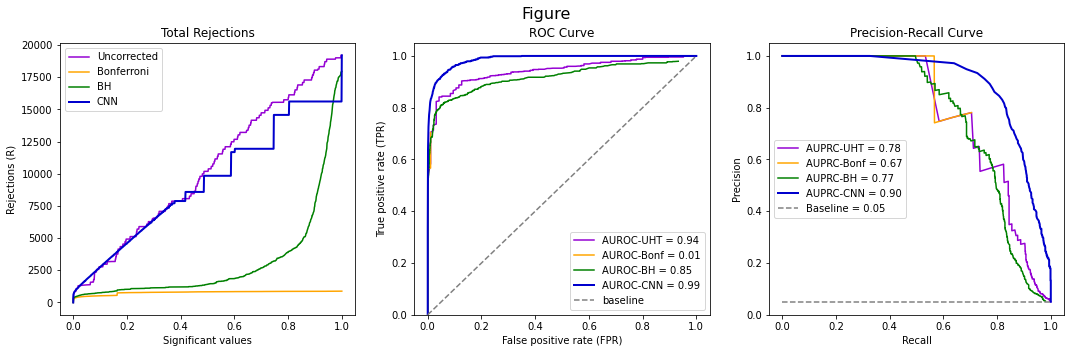

In [68]:
# Plot function
baseline_pr = np.sum(y_test.ravel())/len(y_test.ravel())
plot_performance_metrics(v_grid = grid_significant,
                 out_sig_grid = out_test_trad,
                 baseline_pr = baseline_pr,
                 title = 'Figure', 
                 out_CNN = out_test_DL_CNN)

## Comparing ES in test set:

In [42]:
# Detail of Effect size for test set (small, medium, large)
ES_Test = Effect_sizes[idx_test].copy()
print('Effect size test shape:', ES_Test.shape)

ES_test_small  = np.where(ES_Test < 2)[0]
ES_test_medium = np.where(np.logical_and(ES_Test >= 2,ES_Test < 3))[0]
ES_test_large = np.where(ES_Test >= 3)[0]

print('Effect size test small shape:',ES_test_small.shape)
print('Effect size test medium shape:',ES_test_medium.shape)
print('Effect size test large shape:',ES_test_large.shape)

X_test_small =  X_test[ES_test_small,:].copy()
X_test_medium = X_test[ES_test_medium,:].copy()
X_test_large =  X_test[ES_test_large,:].copy()
print('-----------------------------------------')
print('X_test with small ES:', X_test_small.shape)
print('X_test with medium ES:', X_test_medium.shape)
print('X_test with large ES:', X_test_large.shape)

y_test_small = y_test[ES_test_small].copy()
y_test_medium = y_test[ES_test_medium].copy()
y_test_large = y_test[ES_test_large].copy()

Effect size test shape: (192,)
Effect size test small shape: (28,)
Effect size test medium shape: (16,)
Effect size test large shape: (148,)
X_test with small ES: (28, 100, 100, 1)
X_test with medium ES: (16, 100, 100, 1)
X_test with large ES: (148, 100, 100, 1)


In [43]:
# Evaluating in test set
eval_CNN_test_small = model_CNN.evaluate(X_test_small, y_test_small, verbose = 0)
eval_CNN_test_medium = model_CNN.evaluate(X_test_medium, y_test_medium, verbose = 0)
eval_CNN_test_large = model_CNN.evaluate(X_test_large, y_test_large, verbose = 0)

# Print loss and metrics evaluation test set
print('Small ES:')
print('Test loss  = {:.3f}'.format(eval_CNN_test_small[0]))
print('Test AUPRC = {:.3f}'.format(eval_CNN_test_small[9]))
print('-----------------------')
print('\nMedium ES:')
print('Test loss  = {:.3f}'.format(eval_CNN_test_medium[0]))
print('Test AUPRC = {:.3f}'.format(eval_CNN_test_medium[9]))
print('-----------------------')
print('\nLarge ES:')
print('Test loss  = {:.3f}'.format(eval_CNN_test_large[0]))
print('Test AUPRC = {:.3f}'.format(eval_CNN_test_large[9]))


Small ES:
Test loss  = 0.169
Test AUPRC = 0.234
-----------------------

Medium ES:
Test loss  = 0.096
Test AUPRC = 0.649
-----------------------

Large ES:
Test loss  = 0.022
Test AUPRC = 0.975


In [44]:
# p_values (Traditional procedures)
pvalues_test_small = pvalues_test[ES_test_small].copy()
pvalues_test_medium = pvalues_test[ES_test_medium].copy()
pvalues_test_large = pvalues_test[ES_test_large].copy()


# Model predictions
y_score_CNN_small = model_CNN.predict(X_test_small)
y_score_CNN_medium = model_CNN.predict(X_test_medium)
y_score_CNN_large = model_CNN.predict(X_test_large)


# Compute the metrics manually using the grid:
grid_significant =  np.arange(0, 1.001, 0.001)
#print('Significance levels :', grid_significant)

# Performance UHT, BFC and BHC
n_sim_test_small = y_test_small.shape[0]
out_test_trad_small = MHT_Significant_values(v_grid = grid_significant, 
                                            a_pvalues = pvalues_test_small,
                                            a_nullHypothesis = y_test_small,
                                            n_m = _m,
                                            n_sim = n_sim_test_small)

# Performance ANN for several significant values
out_test_DL_CNN_small = DL_Significant_values(v_grid = grid_significant, 
                                      a_test = y_test_small, 
                                      a_score = y_score_CNN_small)


#-------------------------------
# Medium
n_sim_test_medium = y_test_medium.shape[0]
out_test_trad_medium = MHT_Significant_values(v_grid = grid_significant, 
                                            a_pvalues = pvalues_test_medium,
                                            a_nullHypothesis = y_test_medium,
                                            n_m = _m,
                                            n_sim = n_sim_test_medium)

# Performance ANN for several significant values
out_test_DL_CNN_medium = DL_Significant_values(v_grid = grid_significant, 
                                      a_test = y_test_medium, 
                                      a_score = y_score_CNN_medium)

#-------------------------------
# Large
n_sim_test_large = y_test_large.shape[0]
out_test_trad_large = MHT_Significant_values(v_grid = grid_significant, 
                                            a_pvalues = pvalues_test_large,
                                            a_nullHypothesis = y_test_large,
                                            n_m = _m,
                                            n_sim = n_sim_test_large)

# Performance ANN for several significant values
out_test_DL_CNN_large = DL_Significant_values(v_grid = grid_significant, 
                                      a_test = y_test_large, 
                                      a_score = y_score_CNN_large)

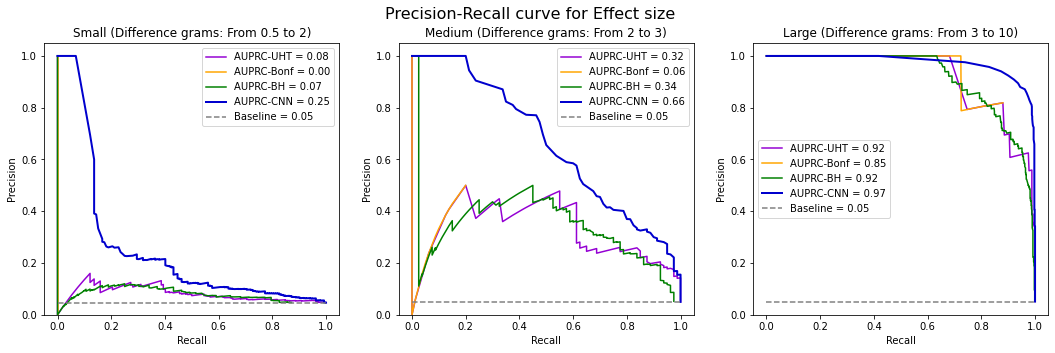

In [56]:
plot_performance_metrics_PR_ES(v_grid = grid_significant,
                     out_sig_grid_small = out_test_trad_small,
                     out_sig_grid_medium = out_test_trad_medium,
                     out_sig_grid_large = out_test_trad_large,
                     baseline_pr_small = np.sum(y_test_small.ravel())/len(y_test_small.ravel()),
                     baseline_pr_medium = np.sum(y_test_medium.ravel())/len(y_test_medium.ravel()),
                     baseline_pr_large = np.sum(y_test_large.ravel())/len(y_test_large.ravel()),
                     title = 'Precision-Recall curve for Effect size', 
                     out_CNN_small = out_test_DL_CNN_small,
                     out_CNN_medium = out_test_DL_CNN_medium,
                     out_CNN_large = out_test_DL_CNN_large,
                     fig_save = 'fig_appex_ES.png')

In [57]:
from google.colab import files
files.download("fig_appex_ES.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Appendix: ANN and CNN

In [ ]:
grid_significant = np.array([0.0001, 0.001, 0.005, 0.01, 0.025, 0.05, 0.1, 0.2, 0.3])

n_sim_test = y_test.shape[0]
# Performance UHT, BFC and BHC
out_test_trad = MHT_Significant_values(v_grid = grid_significant, 
                                            a_pvalues = pvalues_test,
                                            a_nullHypothesis = y_test,
                                            n_m = _m,
                                            n_sim = n_sim_test)

# Performance ANN for several significant values
out_test_DL_ANN = DL_Significant_values(v_grid = grid_significant, 
                                      a_test = y_test,     
                                      a_score = y_score_ANN)

out_test_DL_CNN = DL_Significant_values(v_grid = grid_significant, 
                                      a_test = y_test,     
                                      a_score = y_score_CNN)
								

sig_report = significance_report(out_trad = out_test_trad,
                    out_ANN = out_test_DL_ANN,
                    out_CNN = out_test_DL_CNN)

# Total Rejections:
pd.options.display.float_format = "{:.4f}".format                                     
total_rej = pd.DataFrame.from_dict(sig_report['data_rejections'], orient='index', columns= np.append(0,grid_significant))
total_rej

,0.0000,0.0001,0.0010,0.0050,0.0100,0.0250,0.0500,0.1000,0.2000,0.3000
Uncorrected,0,372,518,827,877,1313,1363,2767,4923,6553
Bonferroni,0,104,226,331,372,434,475,518,760,785
BH,0,152,297,413,457,562,650,758,1019,1139
ANN,0,384,643,858,982,1315,1796,2753,4608,6433
CNN,0,344,640,842,983,1300,1798,2752,4599,6398


In [ ]:
print(total_rej.to_latex(index=True))

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  0.0000 &  0.0001 &  0.0010 &  0.0050 &  0.0100 &  0.0250 &  0.0500 &  0.1000 &  0.2000 &  0.3000 \\
\midrule
Uncorrected &       0 &     372 &     518 &     827 &     877 &    1313 &    1363 &    2767 &    4923 &    6553 \\
Bonferroni  &       0 &     104 &     226 &     331 &     372 &     434 &     475 &     518 &     760 &     785 \\
BH          &       0 &     152 &     297 &     413 &     457 &     562 &     650 &     758 &    1019 &    1139 \\
ANN         &       0 &     384 &     643 &     858 &     982 &    1315 &    1796 &    2753 &    4608 &    6433 \\
CNN         &       0 &     344 &     640 &     842 &     983 &    1300 &    1798 &    2752 &    4599 &    6398 \\
\bottomrule
\end{tabular}



In [ ]:
# Type-I errors
pd.options.display.float_format = "{:.2f}".format
total_TypeI = pd.DataFrame.from_dict(sig_report['data_typeI_error'], orient='index', columns= np.append(0,grid_significant))
total_TypeI

,0.00,0.00,0.00,0.01,0.01,0.03,0.05,0.10,0.20,0.30
Uncorrected,0,0.00,0.00,0.01,0.01,0.03,0.03,0.11,0.22,0.31
Bonferroni,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01
BH,0,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.02,0.02
ANN,0,0.00,0.00,0.00,0.01,0.02,0.05,0.10,0.20,0.30
CNN,0,0.00,0.00,0.00,0.01,0.02,0.05,0.10,0.20,0.30


In [ ]:
print(total_TypeI.to_latex(index=True))

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  0.00 &  0.00 &  0.00 &  0.01 &  0.01 &  0.03 &  0.05 &  0.10 &  0.20 &  0.30 \\
\midrule
Uncorrected &     0 &  0.00 &  0.00 &  0.01 &  0.01 &  0.03 &  0.03 &  0.11 &  0.22 &  0.31 \\
Bonferroni  &     0 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.01 &  0.01 \\
BH          &     0 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.01 &  0.02 &  0.02 \\
ANN         &     0 &  0.00 &  0.00 &  0.00 &  0.01 &  0.02 &  0.05 &  0.10 &  0.20 &  0.30 \\
CNN         &     0 &  0.00 &  0.00 &  0.00 &  0.01 &  0.02 &  0.05 &  0.10 &  0.20 &  0.30 \\
\bottomrule
\end{tabular}



In [ ]:
# Type-II errors
total_TypeII = pd.DataFrame.from_dict(sig_report['data_typeII_error'], orient='index', columns= np.append(0,grid_significant))
total_TypeII

,0.00,0.00,0.00,0.01,0.01,0.03,0.05,0.10,0.20,0.30
Uncorrected,1,0.62,0.47,0.35,0.30,0.24,0.19,0.13,0.08,0.07
Bonferroni,1,0.89,0.77,0.66,0.62,0.55,0.51,0.47,0.42,0.39
BH,1,0.84,0.69,0.58,0.53,0.47,0.42,0.36,0.30,0.26
ANN,1,0.61,0.36,0.21,0.18,0.11,0.08,0.04,0.01,0.00
CNN,1,0.65,0.36,0.23,0.17,0.12,0.08,0.04,0.01,0.00


In [ ]:
print(total_TypeII.to_latex(index=True))

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  0.00 &  0.00 &  0.00 &  0.01 &  0.01 &  0.03 &  0.05 &  0.10 &  0.20 &  0.30 \\
\midrule
Uncorrected &     1 &  0.62 &  0.47 &  0.35 &  0.30 &  0.24 &  0.19 &  0.13 &  0.08 &  0.07 \\
Bonferroni  &     1 &  0.89 &  0.77 &  0.66 &  0.62 &  0.55 &  0.51 &  0.47 &  0.42 &  0.39 \\
BH          &     1 &  0.84 &  0.69 &  0.58 &  0.53 &  0.47 &  0.42 &  0.36 &  0.30 &  0.26 \\
ANN         &     1 &  0.61 &  0.36 &  0.21 &  0.18 &  0.11 &  0.08 &  0.04 &  0.01 &  0.00 \\
CNN         &     1 &  0.65 &  0.36 &  0.23 &  0.17 &  0.12 &  0.08 &  0.04 &  0.01 &  0.00 \\
\bottomrule
\end{tabular}



In [ ]:
# Compute the metrics manually using the grid:
grid_significant =  np.arange(0, 1.001, 0.001)
#print('Significance levels :', grid_significant)

# Performance UHT, BFC and BHC
n_sim_test = y_test.shape[0]
out_test_trad = MHT_Significant_values(v_grid = grid_significant, 
                                            a_pvalues = pvalues_test,
                                            a_nullHypothesis = y_test,
                                            n_m = _m,
                                            n_sim = n_sim_test)

# Performance ANN for several significant values
out_test_DL_ANN = DL_Significant_values(v_grid = grid_significant, 
                                      a_test = y_test,     
                                      a_score = y_score_ANN)

# Performance ANN for several significant values
out_test_DL_CNN = DL_Significant_values(v_grid = grid_significant, 
                                      a_test = y_test,     
                                      a_score = y_score_CNN)

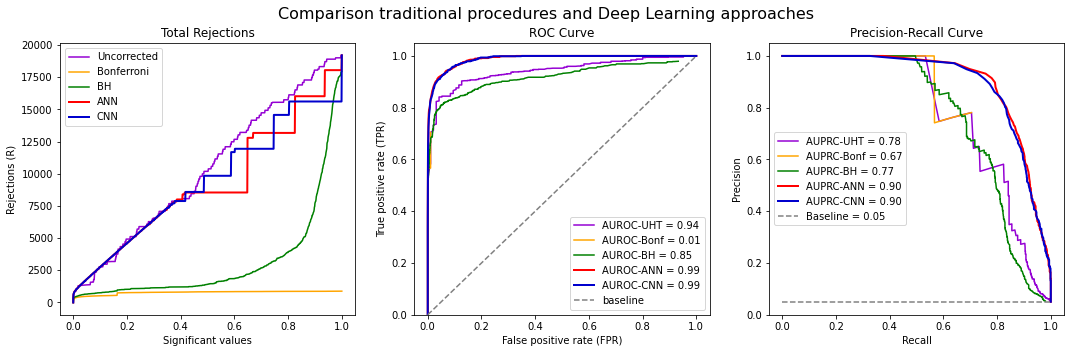

In [ ]:
baseline_pr = np.sum(y_test.ravel())/len(y_test.ravel())
plot_performance_metrics(v_grid = grid_significant,
                 out_sig_grid = out_test_trad,
                 baseline_pr = baseline_pr,
                 title = 'Comparison traditional procedures and Deep Learning approaches', 
                 out_ANN = out_test_DL_ANN,
                 out_CNN = out_test_DL_CNN,
                 fig_save = 'fig3_2_comparison.png')

In [ ]:
import os
# directory
print( os.getcwd() )
print( os.listdir() )


/content
['.config', 'fig3_2_comparison.png', 'sample_data']


In [ ]:
from google.colab import files
#files.download("fig3_1_train_test.png")
files.download("fig3_2_comparison.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Multiple simulations

### Auxiliar functions

In [ ]:
def MHT_Precision_Recall(v_grid,
                           a_pvalues,
                           a_nullHypothesis,
                           n_m,
                           n_sim = 1):
  '''
  Function that computes the performance under several models:

  Input
  -----



  Output
  -----

  roc_values: FPR and TPR
  prec_recall: Precision and recall
  counts: R, fp, tp, fn, tn, type-II error  
  '''

  # Ravel the vectors of v_pvalues and v_nullHypothesis

  v_pvalues = a_pvalues.ravel()
  v_nullHypothesis = a_nullHypothesis.ravel()


  prec_recall_HT = [[0,1]]
  
  for _alpha in v_grid:
    call = np.where(v_pvalues <= _alpha, False, True)
    code_call = np.logical_not(call).astype(int)
    tn, fp, fn, tp = confusion_matrix(v_nullHypothesis, code_call).ravel()
    tpr = tp/(tp+fn)
    if fp == 0:
      prec = 1
    else:
      prec = tp/(tp + fp)
    prec_recall_HT.append([tpr, prec])
    # End for

  #----------------------------------------------------
  # 2) Bonferroni correction
  prec_recall_Bonf = [[0,1]]
  for _alpha in v_grid:
    Bonf_bound = _alpha/n_m
    call = np.where(v_pvalues <= Bonf_bound, False, True)
    code_call = np.logical_not(call).astype(int)
    tn, fp, fn, tp = confusion_matrix(v_nullHypothesis, code_call).ravel()
    tpr = tp/(tp+fn)
    if fp == 0:
      prec = 1
    else:
      prec = tp/(tp + fp)
    prec_recall_Bonf.append([tpr, prec])
    # End for

  #----------------------------------------------------
  # 3) Benjamini Hocheberg FDR
 
  prec_recall_BH = [[0,1]]
  for _q in v_grid:
    BH_bound = np.arange(1,n_m+1)*(_q)/n_m
    BH_bound = np.tile(BH_bound,n_sim)
    call_BH_q = np.where(v_pvalues < BH_bound, False, True)
    code_call_BH_q = np.logical_not(call_BH_q).astype(int)
    tn, fp, fn, tp = confusion_matrix(v_nullHypothesis, code_call_BH_q).ravel()
    tpr = tp/(tp+fn)
    if fp == 0:
      prec = 1
    else:
      prec = tp/(tp + fp)
    prec_recall_BH.append([tpr, prec])
    # End for

  # Outout_dict
  output_dict = {'prec_recall_HT': prec_recall_HT,
                 'prec_recall_Bonf': prec_recall_Bonf,
                 'prec_recall_BH': prec_recall_BH}

  return output_dict

In [ ]:
def compute_AUPRC(vec_seed,N, m, vec_delta,vec_prop,v_grid,iteration = False):
  # For each seed, we compute the AUPRC for traditional and DL
  report_AUPRC = []
  for _seed in vec_seed:
    _image_lbbf = [femaleMiceWeightSimulation(N = N, m = m, p0 = _prop, delta = _delta, seed=_seed) 
               for _delta in vec_delta 
               for _prop in vec_prop]

    n_sim = len(_image_lbbf)
    # Extracting the image as X
    X = np.array([_image_lbbf[index]['X'] for index in range(0, n_sim)])
    Y = np.array([_image_lbbf[index]['Y'] for index in range(0, n_sim)])

    # Extracting the p-values
    p_values = np.array([_image_lbbf[index]['p_value'] for index in range(0, n_sim)])

    # Vector of indices (for extractinf the p-values associated with the testing set)
    indices = np.arange(n_sim)

    # Train and test
    X_train_full, X_test, y_train_full, y_test, idx_train_full, idx_test = train_test_split(X, Y, indices ,random_state = _seed, test_size = 0.2)

    # Train and validation
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state = _seed, test_size = 0.1)

    pvalues_test = p_values[idx_test]

    X_train_full_m = X_train[..., np.newaxis]
    X_valid_full_m = X_valid[..., np.newaxis]
    X_test_full_m  = X_test[..., np.newaxis]

    INPUT_SHAPE  = [m, m, 1]
    OUT_CLASSES = m

    # 2) Hyperparameters:

    ## 2.1) Number of neurons by (hidden) layer
    NEURONS_1 = 500   # of the total pixels
    NEURONS_2 = 250   #  of the total pixels

    ## 2.2) Initial weight
    INITIALIZER = keras.initializers.HeUniform()

    # 3)  compilationHyperparameters
    LOSS_FN   = keras.losses.binary_crossentropy
    OPTIMIZER = keras.optimizers.Nadam()
    METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='AUROC'),
      keras.metrics.AUC(name='AUPRC', curve='PR'), # precision-recall curve
    ]

    # Create the model instance
    model_CNN = create_CNN_model(INPUT_SHAPE,
                     OUT_CLASSES,
                     INITIALIZER,
                     NEURONS_1, NEURONS_2,
                     LOSS_FN,
                     OPTIMIZER,
                     METRICS)

    EPOCHS = 50

    # Early_stopping (avoid overfitting)
    early_stopping = tf.keras.callbacks.EarlyStopping(
      monitor='val_AUPRC', 
      verbose=1,
      patience=10,
      mode='max',
      restore_best_weights=True)

    # 2) fit method

    history_CNN = model_CNN.fit(X_train_full_m, 
                            y_train, 
                            epochs = EPOCHS,
                            validation_data = (X_valid_full_m, y_valid),
                            callbacks=[early_stopping],
                            verbose=0)
    
    y_score_CNN_full_m = model_CNN.predict(X_test_full_m)
    n_sim_test = y_test.shape[0]
    out_test_PR = MHT_Precision_Recall(v_grid = v_grid,
                                       a_pvalues = pvalues_test,
                                       a_nullHypothesis = y_test,
                                       n_m = m,
                                       n_sim = n_sim_test)
											
    recall_HT, prec_HT = zip(*out_test_PR['prec_recall_HT'])
    recall_Bonf, prec_Bonf = zip(*out_test_PR['prec_recall_Bonf'])
    recall_BH, prec_BH = zip(*out_test_PR['prec_recall_BH'])
    report_AUPRC.append([_seed, auc(recall_HT, prec_HT),
                         auc(recall_Bonf, prec_Bonf),
                         auc(recall_BH, prec_BH),
                         average_precision_score(y_test.ravel(), y_score_CNN_full_m.ravel())
                         ])
    if iteration is True:
      print(_seed)
    # End for
  return report_AUPRC


### Simulation

In [ ]:
# Simulation parameters
from numpy.random import default_rng

# 1) Vector of seeds
_seed = 42
rng = default_rng(seed = _seed)
seeds = rng.choice(100, size=20, replace=False)



# 2) Secondary parameters

# Simulation parameters
_m =  100  # Number of test
_N = 12    # Sample Size


# Effect size
min_delta = 0.5   # Min Effect size
max_delta = 10.1  # Max effect size

vec_delta = np.arange(start = min_delta, stop = max_delta, step = 0.1)
vec_prop = np.arange(0.9, 1, 0.01)

grid_significant =  np.arange(0, 1.001, 0.001)

print('Seeds:', seeds)
print('Features:', _m)
print('Sample size:', _N)

Seeds: [63 94 17 89 83 71 12  7 54 49 84 86 45 73  8 68 75 36 61 47]
Features: 100
Sample size: 12


In [ ]:
print(vec_delta)
print(vec_prop)
print(grid_significant)

[ 0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8
  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7  2.8  2.9  3.   3.1  3.2
  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1  4.2  4.3  4.4  4.5  4.6
  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5  5.6  5.7  5.8  5.9  6.
  6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9  7.   7.1  7.2  7.3  7.4
  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3  8.4  8.5  8.6  8.7  8.8
  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7  9.8  9.9 10. ]
[0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99]
[0.    0.001 0.002 ... 0.998 0.999 1.   ]


In [ ]:
# Ftrom the 20 simulations, compute the AUPRC.
report_AUPRC = compute_AUPRC(vec_seed = seeds,
                             N = _N, 
                             m = _m, 
                             vec_delta = vec_delta,
                             vec_prop = vec_prop,
                             v_grid = grid_significant,
                             iteration=True)

In [ ]:
# Sace the report

type(report_AUPRC)
import pickle
with open('report_AUPRC.pkl', 'wb') as f:
  pickle.dump(report_AUPRC, f)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cp /content/report_AUPRC.pkl /content/gdrive/My\ Drive
from google.colab import files
files.download("report_AUPRC.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
_no_sim = len(report_AUPRC)
print(_no_sim)

_, AUPRC_HT,AUPRC_Bonf, AUPRC_BH, AUPRC_CNN = zip(*report_AUPRC)

data = {'HTU': [np.mean(AUPRC_HT), np.std(AUPRC_HT)/np.sqrt(_no_sim), 
                np.min(AUPRC_HT), np.max(AUPRC_HT)], 
        'Bonferroni': [np.mean(AUPRC_Bonf),np.std(AUPRC_Bonf)/np.sqrt(_no_sim),
                       np.min(AUPRC_Bonf), np.max(AUPRC_Bonf)],
        'BH': [np.mean(AUPRC_BH),np.std(AUPRC_BH)/np.sqrt(_no_sim),
               np.min(AUPRC_BH), np.max(AUPRC_BH)],
        'CNN': [np.mean(AUPRC_CNN),np.std(AUPRC_CNN)/np.sqrt(_no_sim),
                np.min(AUPRC_CNN), np.max(AUPRC_CNN)]}
pd.options.display.float_format = "{:.4f}".format   
tb_AUPRC = pd.DataFrame.from_dict(data, orient='index', columns=['Mean', 'SD', 'Min', 'Max'])
tb_AUPRC

20


,Mean,SD,Min,Max
HTU,0.7596,0.0145,0.6441,0.8814
Bonferroni,0.6483,0.0131,0.5512,0.7752
BH,0.7304,0.0125,0.6135,0.8540
CNN,0.8406,0.0116,0.7374,0.9272


In [ ]:
print(tb_AUPRC.to_latex(index=True))  

\begin{tabular}{lrrrr}
\toprule
{} &   Mean &     SD &    Min &    Max \\
\midrule
HTU        & 0.7596 & 0.0145 & 0.6441 & 0.8814 \\
Bonferroni & 0.6483 & 0.0131 & 0.5512 & 0.7752 \\
BH         & 0.7304 & 0.0125 & 0.6135 & 0.8540 \\
CNN        & 0.8406 & 0.0116 & 0.7374 & 0.9272 \\
\bottomrule
\end{tabular}



# P-Value representation

In [58]:
# 1) Download the female mice control population

url = "https://raw.githubusercontent.com/genomicsclass/dagdata/master/inst/extdata/femaleControlsPopulation.csv"
df = pd.read_csv(url)
population = df.to_numpy().flatten()

# 2) Function:
def femaleMiceWeightSimulation_random_p(N = 12, 
                               m = 100, 
                               p0 = 0.90, 
                               delta = 3,  
                               seed = 42,
                               seed_H = 73):
  '''
  Function to create the X image representation and Y response. 
  Additionally, list of pvalues, LBBF
  Input
  -----
  N = 12               # Sample size
  m = 100              # Number of test
  p0 = 0.90            # 10% of diets work, 90% don't
  delta = 3            # Effect size


  Output: Dictionary with the following elements
  ------
  X: matrix dimension mxm with the lbf quotients
  Y: Array with the real values of the null hypothesis (1) null is false, (0) otherwiese
  p_value: List of p-values
  LBBF: list of Lower bound byes factor
  ES: Vector with the apllied vector size.
  P0: Proportion null hypothesis is true
  '''
    
  m0 = np.int16(np.ceil(m*p0))  # Number of test where null hypothesis is true (s)
  m1 = np.int16(m-m0)           # Number of test where null hypothesis is false (saved like int)

  # Ground truth
  nullHypothesis = np.append(np.ones(m0, dtype=bool),np.zeros(m1, dtype=bool) )

  # Sample
  #np.random.seed(seed_H)
  #o = np.random.permutation(m)
  #nullHypothesis = nullHypothesis[o]

  np.random.seed(seed)
  controls   = np.random.choice(population, size = N*m, replace=True).reshape((m,N))
  treatments = np.random.choice(population, size = N*m, replace=True).reshape((m,N))
  treatments[np.logical_not(nullHypothesis),] = treatments[np.logical_not(nullHypothesis),] + delta

  # Computing the pvalues: 
  p_values = np.array([result[1] for result in list(map(stats.ttest_ind, controls, treatments))])

  # Copy the vector of p-values and null hypothesis
  p_values_sorted = p_values.copy()
  H = nullHypothesis.copy()

  # Then, we order the vectors of p-values and null_hyporhesis
  #o = np.argsort(p_values)
  np.random.seed(seed_H)
  o = np.random.permutation(m)
  p_values_sorted = p_values_sorted[o]
  H = H[o]
    
  # Response: Positive class: 1 Detect H0 false (H1 true)
  Y = np.logical_not(H).astype(int)

  # We compute the results under the following procedures:
   
  # 3) Bayesian approach (LBBF)
  lbf = np.where(p_values_sorted < (1/np.exp(1)), -np.exp(1)*p_values_sorted*np.log(p_values_sorted), 1) # Bayes Factor Lower Boun

  # To compute the quotient lbf[t]/lbf, we create a lambda function
  div_lbf = lambda t: lbf[t]/lbf

  # Then, the image is compute for each vector inptu
  image_lbf = np.array([div_lbf(xi) for xi in np.arange(0,m)]).T

  # We compute the maximum lbf quotient, in order to standarize the matrix in the range 0 and 1
  max_lbf = np.max(image_lbf)

  # Input of the ANNs - CNNs
  X = image_lbf/max_lbf
  # otuput of the function
  output_dict = {'X': X,  'Y': Y, 
                 'p_value': p_values_sorted,  'LBBF':  lbf,
                 'ES': delta, 'Prop_H0': p0}

  return output_dict

In [59]:
def MHT_Significant_values_random_p(v_grid,
                           a_pvalues,
                           a_nullHypothesis,
                           n_m,
                           n_sim = 1):
  '''
  Function that computes the performance under several models:

  Input
  -----



  Output
  -----

  roc_values: FPR and TPR
  prec_recall: Precision and recall
  counts: R, fp, tp, fn, tn, type-II error  
  '''

  # Ravel the vectors of v_pvalues and v_nullHypothesis

  v_pvalues = a_pvalues.ravel()
  v_nullHypothesis = a_nullHypothesis.ravel()

  roc_values_HT = [[0,0]]
  prec_recall_HT = [[0,1]]
  counts_HT = [[0, 0, 0, np.sum(v_nullHypothesis), len(v_nullHypothesis) - np.sum(v_nullHypothesis),1]]
  
  for _alpha in v_grid:
    call = np.where(v_pvalues <= _alpha, False, True)
    code_call = np.logical_not(call).astype(int)
    tn, fp, fn, tp = confusion_matrix(v_nullHypothesis, code_call).ravel()
    R = fp + tp
    fpr = fp/(fp+tn)
    tpr = tp/(tp+fn)
    #prec = tp/(tp + fp)
    if fp == 0:
      prec = 1
    else:
      prec = tp/(tp + fp)
    # Type-II error
    fnr = fn/(fn + tp)
    roc_values_HT.append([fpr, tpr])
    prec_recall_HT.append([tpr, prec])
    counts_HT.append([R, fp, tp, fn, tn, fnr])
    # End for

  #----------------------------------------------------
  # 2) Bonferroni correction
  roc_values_Bonf = [[0,0]]
  prec_recall_Bonf = [[0,1]]
  counts_Bonf = [[0, 0, 0, np.sum(v_nullHypothesis), len(v_nullHypothesis) - np.sum(v_nullHypothesis),1]]
  for _alpha in v_grid:
    Bonf_bound = _alpha/n_m
    call = np.where(v_pvalues <= Bonf_bound, False, True)
    code_call = np.logical_not(call).astype(int)
    tn, fp, fn, tp = confusion_matrix(v_nullHypothesis, code_call).ravel()
    R = fp + tp
    fpr = fp/(fp+tn)
    tpr = tp/(tp+fn)
    #prec = tp/(tp + fp)
    if fp == 0:
      prec = 1
    else:
      prec = tp/(tp + fp)
    
    # Type-II error
    fnr = fn/(fn + tp)
    roc_values_Bonf.append([fpr, tpr])
    prec_recall_Bonf.append([tpr, prec])
    counts_Bonf.append([R, fp, tp, fn, tn, fnr])
    # End for

  #----------------------------------------------------
  # 3) Benjamini Hocheberg FDR
  
  roc_values_BH = [[0,0]]
  prec_recall_BH = [[0,1]]
  
  order_ind = np.argsort(a_pvalues, axis = 1)
  sorted_p_values = np.take_along_axis(a_pvalues, order_ind, axis = 1)
  sorted_H = np.take_along_axis(a_nullHypothesis, order_ind, axis = 1)

  v_pvalues = sorted_p_values.ravel()
  v_nullHypothesis = sorted_H.ravel()

  counts_BH = [[0,0,0,np.sum(v_nullHypothesis),len(v_nullHypothesis) - np.sum(v_nullHypothesis),1]]

  for _q in v_grid:
    BH_bound = np.arange(1,n_m+1)*(_q)/n_m
    BH_bound = np.tile(BH_bound,n_sim)
    call_BH_q = np.where(v_pvalues < BH_bound, False, True)
    code_call_BH_q = np.logical_not(call_BH_q).astype(int)
    tn, fp, fn, tp = confusion_matrix(v_nullHypothesis, code_call_BH_q).ravel()
    R = fp + tp
    fpr = fp/(fp + tn)
    tpr = tp/(tp+fn)
    if fp == 0:
      prec = 1
    else:
      prec = tp/(tp + fp)
    
    # Type-II error
    fnr = fn/(fn + tp)
    roc_values_BH.append([fpr, tpr])
    prec_recall_BH.append([tpr, prec])
    counts_BH.append([R, fp, tp, fn, tn, fnr])
    # End for

  # Outout_dict
  output_dict = {'roc_values_HT': roc_values_HT, 'prec_recall_HT': prec_recall_HT, 'counts_HT' : counts_HT,
                 'roc_values_Bonf': roc_values_Bonf, 'prec_recall_Bonf': prec_recall_Bonf, 'counts_Bonf' : counts_Bonf,
                 'roc_values_BH': roc_values_BH, 'prec_recall_BH': prec_recall_BH, 'counts_BH' : counts_BH}

  return output_dict

In [60]:
# Simulation parameters

_m =  100  # Number of test
_N = 12    # Sample Size

print('Number of test:', _m)
print('Sample Size:', _N)# Effect size
print('----------------------------')

min_delta = 0.5   # Min Effect size
max_delta = 10.1  # Max effect size

vec_delta = np.arange(start = min_delta, stop = max_delta, step = 0.1)
print('Number of ES:', len(vec_delta))
print(vec_delta)
print('----------------------------')

## Proportion of (true) null hypothesis
vec_prop = np.arange(0.9, 1, 0.01)
print('Number of Proportion H0:', len(vec_prop))
print('Proportion Null Hypothesis true:', vec_prop)

Number of test: 100
Sample Size: 12
----------------------------
Number of ES: 96
[ 0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8
  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7  2.8  2.9  3.   3.1  3.2
  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1  4.2  4.3  4.4  4.5  4.6
  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5  5.6  5.7  5.8  5.9  6.
  6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9  7.   7.1  7.2  7.3  7.4
  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3  8.4  8.5  8.6  8.7  8.8
  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7  9.8  9.9 10. ]
----------------------------
Number of Proportion H0: 10
Proportion Null Hypothesis true: [0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99]


In [61]:
# We simulate 96 for each Effect size (delta) and 10 different null (true) hypothesis
_image_lbbf = [femaleMiceWeightSimulation_random_p(N = _N, m = _m, p0 = _prop, delta = _delta, seed_H= np.int16(np.floor(_m*_prop*_delta))) 
               for _delta in vec_delta 
               for _prop in vec_prop]

# Number of simulations:
n_sim = len(_image_lbbf)
print('Number of simulations:' , n_sim)

Number of simulations: 960


In [62]:
# Extracting the image as X
X = np.array([_image_lbbf[index]['X'] for index in range(0, n_sim)])
print('X shape:', X.shape)

# Extracting the response (Y)
Y = np.array([_image_lbbf[index]['Y'] for index in range(0, n_sim)])
print('Y shape:', Y.shape)

# Extracting the p-values ()
p_values = np.array([_image_lbbf[index]['p_value'] for index in range(0, n_sim)])
print('P-values shape:', p_values.shape)

Effect_sizes = np.array([_image_lbbf[index]['ES'] for index in range(0, n_sim)])
print('Effect sizes shape:', Effect_sizes.shape)

Prop_H0 = np.array([_image_lbbf[index]['Prop_H0'] for index in range(0, n_sim)])
print('Prop H0 shape:', Prop_H0.shape)

X shape: (960, 100, 100)
Y shape: (960, 100)
P-values shape: (960, 100)
Effect sizes shape: (960,)
Prop H0 shape: (960,)


In [63]:
# Vector of indices (for extractinf the p-values associated with the testing set)
indices = np.arange(n_sim)

# Train and test
X_train_full, X_test, y_train_full, y_test, idx_train_full, idx_test = train_test_split(X, Y, indices ,random_state = 42, test_size = 0.2)

# Train and validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state = 42, test_size = 0.1)


# Dimensions
print('X_train shape:', X_train.shape)
print('X_valid shape:', X_valid.shape)
print('X_test shape:', X_test.shape)

X_train shape: (691, 100, 100)
X_valid shape: (77, 100, 100)
X_test shape: (192, 100, 100)


In [64]:
# Extracting the p-values of test set

pvalues_test = p_values[idx_test]

# Distribution of Proportion H0 train and test
Prop_H0_test = Prop_H0[idx_test]
Prop_H0_train_full = Prop_H0[idx_train_full]

# Distribution of Effect size train and test
Effect_sizes_train_full = Effect_sizes[idx_train_full]
Effect_sizes_test = Effect_sizes[idx_test]

In [ ]:
unique, counts = np.unique(y_train_full.ravel(), return_counts=True)
pd.DataFrame.from_dict(dict(zip(unique, counts)), orient='index', columns=['Quantity'])

,Quantity
0,72876
1,3924


In [ ]:
unique, counts = np.unique(y_test.ravel(), return_counts=True)
pd.DataFrame.from_dict(dict(zip(unique, counts)), orient='index', columns=['Quantity'])

,Quantity
0,18228
1,972


## ANN

In [66]:
# Refresh: Number of (null) hypothesis test
print('Total Null hypothesis:', _m)
print('--------------------------')

# Multilabel classification: Define the number of elements of input/output in the NN
# same as (_m)

INPUT_SHAPE_ANN  = [_m, _m]
OUT_CLASSES_ANN = _m

# print
print('Input: Dimension image LBBF: ', INPUT_SHAPE_ANN)
print('Output: Number of labels', OUT_CLASSES_ANN)

# Define a simple sequential model
def create_ANN_model(INPUT_SHAPE,
                     OUT_CLASSES,
                     INITIALIZER,
                     NEURONS_1, NEURONS_2,
                     LOSS_FN,
                     OPTIMIZER,
                     METRICS,
                     SEED = 42):

  # 0)
  keras.backend.clear_session()

  # 1) Set seed
  np.random.seed(SEED)
  tf.random.set_seed(SEED)

  # 2) Sequential model
  model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = INPUT_SHAPE),
    keras.layers.Dense(NEURONS_1, 
                       kernel_initializer = INITIALIZER,
                       activation = "relu"),
    keras.layers.Dense(NEURONS_2, 
                       kernel_initializer = INITIALIZER,
                       activation = "relu"),
    keras.layers.Dense(OUT_CLASSES, 
                       activation = "sigmoid")
  ])

  #2) compile method
  model.compile(loss      = LOSS_FN,
                optimizer = OPTIMIZER,
                metrics   = METRICS)
  
  return model

# 2) Hyperparameters:

## 2.1) Number of neurons by (hidden) layer
NEURONS_1 = 500  # 5% of the total pixels
NEURONS_2 = 250  # 2.5% of the total pixels

## 2.2) Initial weight
INITIALIZER = keras.initializers.HeUniform()

# 3)  compilationHyperparameters
LOSS_FN   = keras.losses.binary_crossentropy
OPTIMIZER = keras.optimizers.Nadam()
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='AUROC'),
      keras.metrics.AUC(name='AUPRC', curve='PR'), # precision-recall curve
]

# Create the model instance
model_ANN_r = create_ANN_model(INPUT_SHAPE_ANN,
                     OUT_CLASSES_ANN,
                     INITIALIZER,
                     NEURONS_1, NEURONS_2,
                     LOSS_FN,
                     OPTIMIZER,
                     METRICS)

# Print Model summary (model's architecture)
model_ANN_r.summary()

Total Null hypothesis: 100
--------------------------
Input: Dimension image LBBF:  [100, 100]
Output: Number of labels 100
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 500)               5000500   
_________________________________________________________________
dense_1 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               25100     
Total params: 5,150,850
Trainable params: 5,150,850
Non-trainable params: 0
_________________________________________________________________


In [67]:
# Set the correct initial bias
eval_ANN_train = model_ANN_r.evaluate(X_train, y_train, verbose=0)

# Print loss: Correct if loss is greater > 1
print('Train loss = {:.3f}'.format(eval_ANN_train[0]))
print('-----------------------')
print('Example predictions:')
model_ANN_r.predict(X_train[0:1,:,:])

Train loss = 0.691
-----------------------
Example predictions:


array([[0.5219487 , 0.45883152, 0.49218473, 0.51167595, 0.5285717 ,
        0.49104843, 0.46358123, 0.5242026 , 0.5745715 , 0.47676355,
        0.5071564 , 0.4923895 , 0.54940957, 0.4580072 , 0.5178907 ,
        0.47735038, 0.5254209 , 0.441752  , 0.4069022 , 0.5412645 ,
        0.46218932, 0.5133553 , 0.5025838 , 0.45157367, 0.4922957 ,
        0.56512403, 0.4752313 , 0.47793022, 0.50820565, 0.49266773,
        0.5207128 , 0.44608706, 0.42072278, 0.5110492 , 0.4716431 ,
        0.5406767 , 0.47050482, 0.5077559 , 0.54713786, 0.5149898 ,
        0.53604954, 0.51074207, 0.5517235 , 0.48380846, 0.5190912 ,
        0.536447  , 0.50180477, 0.4707368 , 0.51575863, 0.53982466,
        0.52394253, 0.47057408, 0.5060621 , 0.48329484, 0.5597072 ,
        0.4646741 , 0.4774704 , 0.48303568, 0.48004577, 0.46210486,
        0.44728875, 0.5122511 , 0.4948865 , 0.46890053, 0.43506715,
        0.58051306, 0.55234784, 0.4917805 , 0.5157324 , 0.48194295,
        0.42717725, 0.52386904, 0.52335095, 0.49

In [68]:
# Model Train

# 1) Hypeparameters
EPOCHS = 50

# Early_stopping (avoid overfitting)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_AUPRC', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

# 2) fit method

start_time = time.time()

history_ANN_r = model_ANN_r.fit(X_train, 
                        y_train, 
                        epochs = EPOCHS,
                        validation_data = (X_valid, y_valid),
                        callbacks=[early_stopping],
                        verbose=0)

print('Elapsed time (seconds) = {:.3f}'.format(time.time() - start_time))

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Elapsed time (seconds) = 61.171


In [69]:
eval_ANN_train = model_ANN_r.evaluate(X_train, y_train, verbose=0)

# Print loss and metrics evaluation train set
print('Train loss = {:.3f}'.format(eval_ANN_train[0]))
print('-----------------------')
print('Train Accuracy  = {:.3f}'.format(eval_ANN_train[5]))
print('Train Precision = {:.3f}'.format(eval_ANN_train[6]))
print('Train Recall    = {:.3f}'.format(eval_ANN_train[7]))
print('Train AUROC     = {:.3f}'.format(eval_ANN_train[8]))
print('Train AUPRC     = {:.3f}'.format(eval_ANN_train[9]))

Train loss = 0.005
-----------------------
Train Accuracy  = 0.999
Train Precision = 0.988
Train Recall    = 0.988
Train AUROC     = 1.000
Train AUPRC     = 0.999


In [70]:
eval_ANN_test = model_ANN_r.evaluate(X_test, y_test, verbose = 0)

# Print loss and metrics evaluation test set
print('Test loss = {:.3f}'.format(eval_ANN_test[0]))
print('-----------------------')
print('Test Accuracy  = {:.3f}'.format(eval_ANN_test[5]))
print('Test Precision = {:.3f}'.format(eval_ANN_test[6]))
print('Test Recall    = {:.3f}'.format(eval_ANN_test[7]))
print('Test AUROC     = {:.3f}'.format(eval_ANN_test[8]))
print('Test AUPRC     = {:.3f}'.format(eval_ANN_test[9]))

Test loss = 0.360
-----------------------
Test Accuracy  = 0.955
Test Precision = 0.605
Test Recall    = 0.309
Test AUROC     = 0.721
Test AUPRC     = 0.361


y_score shape: (192, 100)
---------------------------------


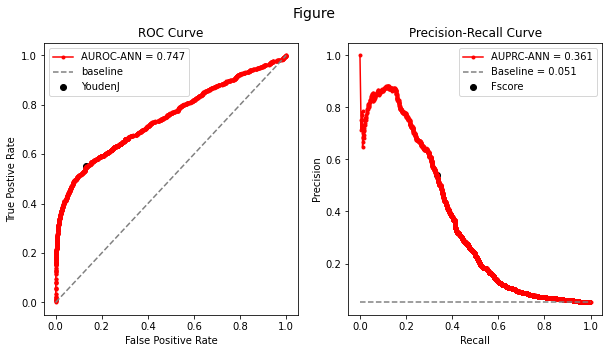

In [71]:
# Model predictions
y_score_ANN = model_ANN_r.predict(X_test)
print('y_score shape:', y_score_ANN.shape)
print('---------------------------------')

# calculate ROC and Precision-Recall curves
stats_ANN = plot_ROC_PRC_score(y_test = y_test,
                           y_score = y_score_ANN,
                           plot = True,
                           type_DL = 'ANN')

## CNN

In [72]:
# Resize the inputs (X_train, X_val, X_test) adding the channel

# No. of channels = 1 (gray scale)

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

## Print dimensions for inputs
print('X_train shape:', X_train.shape)
print('X_valid shape:', X_valid.shape)
print('X_test shape: ', X_test.shape)
print('----------------------------')

X_train shape: (691, 100, 100, 1)
X_valid shape: (77, 100, 100, 1)
X_test shape:  (192, 100, 100, 1)
----------------------------


In [73]:
# Refresh: Number of (null) hypothesis test
print('Total Null hypothesis:', _m)
print('--------------------------')

# Multilabel classification: Define the number of elements of input/output in the NN
# same as (_m)

CHANNELS = 1
INPUT_SHAPE  = [_m, _m, CHANNELS]
OUT_CLASSES = _m

# print
print('Input: Dimension image LBBF: ', INPUT_SHAPE)
print('Output: Number of labels', OUT_CLASSES)

# Define a simple sequential model
def create_CNN_model(INPUT_SHAPE,
                     OUT_CLASSES,
                     INITIALIZER,
                     NEURONS_1, NEURONS_2,
                     LOSS_FN,
                     OPTIMIZER,
                     METRICS,
                     SEED = 42):

  # 0)
  keras.backend.clear_session()

  # 1) Set seed
  np.random.seed(SEED)
  tf.random.set_seed(SEED)

  # 2) Sequential model
  model = keras.models.Sequential([
    keras.layers.Conv2D(filters = 2, 
                        kernel_size = 3, 
                        padding = "same", 
                        activation = "relu",
                        kernel_initializer = INITIALIZER,
                        input_shape = INPUT_SHAPE),
    keras.layers.Flatten(),
    keras.layers.Dense(NEURONS_1, activation="relu", kernel_initializer=INITIALIZER),
    keras.layers.Dense(NEURONS_2, activation="relu", kernel_initializer=INITIALIZER),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(OUT_CLASSES, activation="sigmoid")
  ])

  #2) compile method
  model.compile(loss      = LOSS_FN,
                optimizer = OPTIMIZER,
                metrics   = METRICS)
  
  return model

# 2) Hyperparameters:

## 2.1) Number of neurons by (hidden) layer
NEURONS_1 = 500   # of the total pixels
NEURONS_2 = 250   #  of the total pixels

## 2.2) Initial weight
INITIALIZER = keras.initializers.HeUniform()

# 3)  compilationHyperparameters
LOSS_FN   = keras.losses.binary_crossentropy
OPTIMIZER = keras.optimizers.Nadam()
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='AUROC'),
      keras.metrics.AUC(name='AUPRC', curve='PR'), # precision-recall curve
]

# Create the model instance
model_CNN_r = create_CNN_model(INPUT_SHAPE,
                     OUT_CLASSES,
                     INITIALIZER,
                     NEURONS_1, NEURONS_2,
                     LOSS_FN,
                     OPTIMIZER,
                     METRICS)

# Print Model summary (model's architecture)
model_CNN_r.summary()

Total Null hypothesis: 100
--------------------------
Input: Dimension image LBBF:  [100, 100, 1]
Output: Number of labels 100
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 2)       20        
_________________________________________________________________
flatten (Flatten)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 500)               10000500  
_________________________________________________________________
dense_1 (Dense)              (None, 250)               125250    
_________________________________________________________________
dropout (Dropout)            (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               25100 

In [74]:
# Set the correct initial bias
eval_CNN_train = model_CNN_r.evaluate(X_train, y_train, verbose=0)

# Print loss: Correct if loss is greater > 1
print('Train loss = {:.3f}'.format(eval_CNN_train[0]))
print('-----------------------')
print('Example predictions:')
model_CNN_r.predict(X_train[0:1,])

Train loss = 0.697
-----------------------
Example predictions:


array([[0.49391243, 0.53635645, 0.49584812, 0.4667062 , 0.47101113,
        0.4749815 , 0.5226845 , 0.5006335 , 0.49107426, 0.45791614,
        0.49078682, 0.49759424, 0.5050656 , 0.49988425, 0.5396269 ,
        0.5191481 , 0.48831323, 0.53031445, 0.5022259 , 0.5482756 ,
        0.5142535 , 0.51377875, 0.5117477 , 0.5092806 , 0.5225421 ,
        0.49615198, 0.48817223, 0.44358757, 0.54450756, 0.5463617 ,
        0.52754635, 0.48078102, 0.49479955, 0.52122325, 0.5039036 ,
        0.46699718, 0.54416597, 0.51233494, 0.49277398, 0.5316449 ,
        0.5629101 , 0.5347784 , 0.5056225 , 0.52752674, 0.5181133 ,
        0.4975716 , 0.522973  , 0.5068625 , 0.4707483 , 0.5138719 ,
        0.46308848, 0.49888498, 0.47965562, 0.5121493 , 0.45625812,
        0.5148439 , 0.49488136, 0.5098052 , 0.5106508 , 0.4766081 ,
        0.50445527, 0.5109024 , 0.5121599 , 0.49667233, 0.5120217 ,
        0.5308467 , 0.4640332 , 0.47547454, 0.47796836, 0.4856074 ,
        0.4742133 , 0.50006825, 0.54367495, 0.51

In [75]:
# Model Train

# 1) Hypeparameters
EPOCHS = 50

# Early_stopping (avoid overfitting)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_AUPRC', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

# 2) fit method

start_time = time.time()

history_CNN_r = model_CNN_r.fit(X_train, 
                            y_train, 
                            epochs = EPOCHS,
                            validation_data = (X_valid, y_valid),
                            callbacks=[early_stopping],
                            verbose=0)
print('Elapsed time (seconds) = {:.3f}'.format(time.time() - start_time))

Elapsed time (seconds) = 229.511


In [76]:
eval_CNN_train = model_CNN_r.evaluate(X_train, y_train, verbose=0)

# Print loss and metrics evaluation train set
print('Train loss = {:.3f}'.format(eval_CNN_train[0]))
print('-----------------------')
print('Train Accuracy  = {:.3f}'.format(eval_CNN_train[5]))
print('Train Precision = {:.3f}'.format(eval_CNN_train[6]))
print('Train Recall    = {:.3f}'.format(eval_CNN_train[7]))
print('Train AUROC     = {:.3f}'.format(eval_CNN_train[8]))
print('Train AUPRC     = {:.3f}'.format(eval_CNN_train[9]))

Train loss = 0.007
-----------------------
Train Accuracy  = 0.998
Train Precision = 0.999
Train Recall    = 0.971
Train AUROC     = 1.000
Train AUPRC     = 1.000


In [77]:
eval_CNN_test = model_CNN_r.evaluate(X_test, y_test, verbose = 0)

# Print loss and metrics evaluation test set
print('Test loss = {:.3f}'.format(eval_CNN_test[0]))
print('-----------------------')
print('Test Accuracy  = {:.3f}'.format(eval_CNN_test[5]))
print('Test Precision = {:.3f}'.format(eval_CNN_test[6]))
print('Test Recall    = {:.3f}'.format(eval_CNN_test[7]))
print('Test AUROC     = {:.3f}'.format(eval_CNN_test[8]))
print('Test AUPRC     = {:.3f}'.format(eval_CNN_test[9]))

Test loss = 0.264
-----------------------
Test Accuracy  = 0.958
Test Precision = 0.689
Test Recall    = 0.308
Test AUROC     = 0.745
Test AUPRC     = 0.403


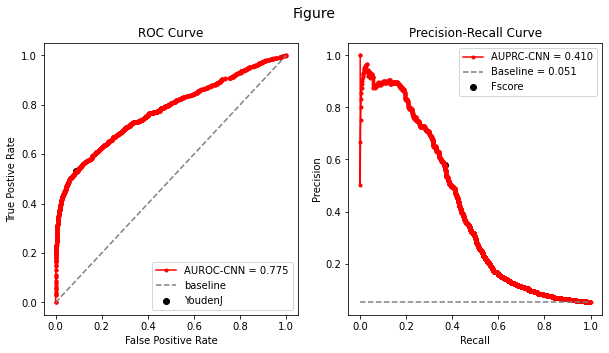

In [78]:
# Model predictions
y_score_CNN = model_CNN_r.predict(X_test)

# calculate ROC and Precision-Recall curves
stats_CNN = plot_ROC_PRC_score(y_test = y_test,
                           y_score = y_score_CNN,
                           plot = True,
                           type_DL = 'CNN')

In [79]:
# Compute the metrics manually using the grid:
grid_significant =  np.arange(0, 1.001, 0.001)
#print('Significance levels :', grid_significant)

# Performance UHT, BFC and BHC
n_sim_test = y_test.shape[0]
out_test_trad = MHT_Significant_values_random_p(v_grid = grid_significant, 
                                            a_pvalues = pvalues_test,
                                            a_nullHypothesis = y_test,
                                            n_m = _m,
                                            n_sim = n_sim_test)

# Performance ANN for several significant values
out_test_DL_ANN = DL_Significant_values(v_grid = grid_significant, 
                                      a_test = y_test,     
                                      a_score = y_score_ANN)

# Performance ANN for several significant values
out_test_DL_CNN = DL_Significant_values(v_grid = grid_significant, 
                                      a_test = y_test,     
                                      a_score = y_score_CNN)

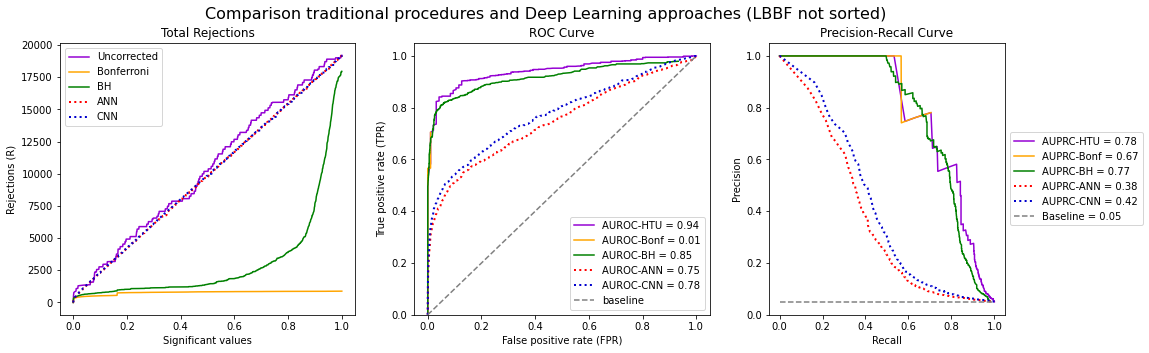

In [80]:
def plot_performance_metrics_random_p(v_grid,
                     out_sig_grid,
                     baseline_pr,
                     title = 'Figure', 
                     out_ANN = None,
                     out_CNN = None,
                     fig_save = None):

  ext_grid = np.append(0, v_grid)

  # HT Uncorrected
  rej_HT, fp_HT, tp_HT, fn_HT,_,_ = zip(*out_sig_grid['counts_HT'])
  fpr_HT, tpr_HT = zip(*out_sig_grid['roc_values_HT'])
  recall_HT, prec_HT = zip(*out_sig_grid['prec_recall_HT'])

  # Bonferroni correction
  rej_Bonf, fp_Bonf, tp_Bonf, fn_Bonf,_,_ = zip(*out_sig_grid['counts_Bonf'])
  fpr_Bonf, tpr_Bonf = zip(*out_sig_grid['roc_values_Bonf'])
  recall_Bonf, prec_Bonf = zip(*out_sig_grid['prec_recall_Bonf'])

  # BH
  rej_BH, fp_BH, tp_BH, fn_BH,_,_ = zip(*out_sig_grid['counts_BH'])
  fpr_BH, tpr_BH = zip(*out_sig_grid['roc_values_BH'])
  recall_BH, prec_BH = zip(*out_sig_grid['prec_recall_BH'])

  if out_ANN is not None:
    # ANN results
    rej_ANN, fp_ANN, tp_ANN, fn_ANN,_,_ = zip(*out_ANN['counts_DL'])
    fpr_ANN, tpr_ANN = zip(*out_ANN['roc_values_DL'])
    recall_ANN, prec_ANN = zip(*out_ANN['prec_recall_DL'])

  if out_CNN is not None:
    # CNN results
    rej_CNN, fp_CNN, tp_CNN, fn_CNN,_,_ = zip(*out_CNN['counts_DL'])
    fpr_CNN, tpr_CNN = zip(*out_CNN['roc_values_DL'])
    recall_CNN, prec_CNN = zip(*out_CNN['prec_recall_DL'])

  fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,5))

  # Subplot Rejection
  ax1.plot(ext_grid,rej_HT,'-', color='darkviolet',label = 'Uncorrected')
  ax1.plot(ext_grid,rej_Bonf, '-', color='orange', label = 'Bonferroni')
  ax1.plot(ext_grid,rej_BH, '-', color='green' ,label = 'BH')
  if out_ANN is not None:
    ax1.plot(ext_grid,rej_ANN, ':', linewidth = 2, color='red', label = 'ANN')
  if out_CNN is not None:
    ax1.plot(ext_grid,rej_CNN, ':', linewidth = 2, color='mediumblue', label = 'CNN')
  ax1.set_title('Total Rejections')
  ax1.set(xlabel='Significant values', ylabel = 'Rejections (R)')
  ax1.legend()

  # Subplot ROC
  ax2.plot(fpr_HT,tpr_HT,'-', color='darkviolet', label = 'AUROC-HTU = {:.2f}'.format(auc(fpr_HT,tpr_HT)))
  ax2.plot(fpr_Bonf,tpr_Bonf, '-',color='orange', label = 'AUROC-Bonf = {:.2f}'.format(auc(fpr_Bonf,tpr_Bonf)))
  ax2.plot(fpr_BH,tpr_BH, '-' , color='green' , label = 'AUROC-BH = {:.2f}'.format(auc(fpr_BH,tpr_BH)))
  if out_ANN is not None:
    ax2.plot(fpr_ANN,tpr_ANN,':', linewidth = 2, color='red', label = 'AUROC-ANN = {:.2f}'.format(auc(fpr_ANN,tpr_ANN)))
  if out_CNN is not None:
    ax2.plot(fpr_CNN,tpr_CNN,':', linewidth = 2, color='mediumblue', label = 'AUROC-CNN = {:.2f}'.format(auc(fpr_CNN,tpr_CNN)))
  ax2.plot(np.linspace(0, 1*np.max(fpr_HT), 100),
         np.linspace(0, 1*np.max(fpr_HT), 100),
         label='baseline',
         linestyle='--',
         color = 'grey')
  ax2.set_title('ROC Curve')
  ax2.set(xlabel='False positive rate (FPR)', ylabel='True positive rate (TPR)')
  ax2.set_ylim([0, 1.05])
  ax2.legend()

  # Subplot Precision-Recall
  ax3.plot(recall_HT,prec_HT,'-', color='darkviolet', label = 'AUPRC-HTU = {:.2f}'.format(auc(recall_HT,prec_HT)))
  ax3.plot(recall_Bonf,prec_Bonf, '-',color='orange', label = 'AUPRC-Bonf = {:.2f}'.format(auc(recall_Bonf,prec_Bonf)))
  ax3.plot(recall_BH,prec_BH, '-' , color='green' , label = 'AUPRC-BH = {:.2f}'.format(auc(recall_BH,prec_BH)))
  if out_ANN is not None:
    ax3.plot(recall_ANN,prec_ANN,':', linewidth = 2 ,color='red', label = 'AUPRC-ANN = {:.2f}'.format(auc(recall_ANN,prec_ANN)))
  if out_CNN is not None:
    ax3.plot(recall_CNN,prec_CNN,':', linewidth = 2 ,color='mediumblue', label = 'AUPRC-CNN = {:.2f}'.format(auc(recall_CNN,prec_CNN)))
  ax3.plot([0,1], [baseline_pr,baseline_pr], linestyle='--', label = 'Baseline = {:.2f}'.format(baseline_pr), color = 'grey')
  ax3.set_title('Precision-Recall Curve')
  ax3.set(xlabel='Recall', ylabel='Precision')
  ax3.set_ylim([0, 1.05])
  #ax3.legend()
  box = ax3.get_position()
  ax3.set_position([box.x0, box.y0, box.width * 0.8, box.height])
  ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))


  fig.suptitle(title, fontsize=16)
  fig.show()
  if fig_save is not None:
    fig.savefig(fig_save)


baseline_pr = np.sum(y_test.ravel())/len(y_test.ravel())
plot_performance_metrics_random_p(v_grid = grid_significant,
                 out_sig_grid = out_test_trad,
                 baseline_pr = baseline_pr,
                 title = 'Comparison traditional procedures and Deep Learning approaches (LBBF not sorted)', 
                 out_ANN = out_test_DL_ANN,
                 out_CNN = out_test_DL_CNN,
                 fig_save = 'fig3_2_comparison_random.png')

In [81]:
from google.colab import files
files.download("fig3_2_comparison_random.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Correlations

## Only LBBF

In [69]:
LBBF_bounds = np.array([_image_lbbf[index]['LBBF'] for index in range(0, n_sim)])
print('LBBF shape:', LBBF_bounds.shape)

LBBF_bounds_test = LBBF_bounds[idx_test]
print('Shape LBBF_bounds_test: ', LBBF_bounds_test.shape)

# Element wise (Only the diagonal elements)
X_test_element_wise = np.zeros((X_test.shape[0],_m,_m))

# Assign into the diagonal
np.einsum('ijj->ij', X_test_element_wise)[...] = LBBF_bounds_test
X_test_element_wise  = X_test_element_wise[..., np.newaxis]
print('Input diagonal LBBF:',X_test_element_wise.shape)

LBBF shape: (960, 100)
Shape LBBF_bounds_test:  (192, 100)
Input diagonal LBBF: (192, 100, 100, 1)


Test loss = 0.724
-----------------------
Test Accuracy  = 0.949
Test Precision = 0.000
Test Recall    = 0.000
Test AUROC     = 0.500
Test AUPRC     = 0.051


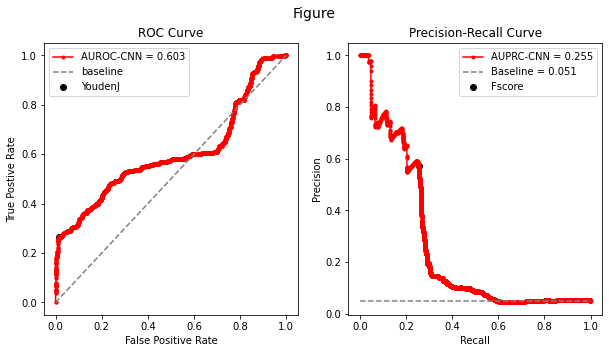

In [70]:
eval_CNN_test = model_CNN.evaluate(X_test_element_wise, y_test, verbose = 0)

# Print loss and metrics evaluation test set
print('Test loss = {:.3f}'.format(eval_CNN_test[0]))
print('-----------------------')
print('Test Accuracy  = {:.3f}'.format(eval_CNN_test[5]))
print('Test Precision = {:.3f}'.format(eval_CNN_test[6]))
print('Test Recall    = {:.3f}'.format(eval_CNN_test[7]))
print('Test AUROC     = {:.3f}'.format(eval_CNN_test[8]))
print('Test AUPRC     = {:.3f}'.format(eval_CNN_test[9]))
y_score_CNN_element_wise = model_CNN.predict(X_test_element_wise)

# calculate ROC and Precision-Recall curves
stats_CNN = plot_ROC_PRC_score(y_test = y_test,
                           y_score = y_score_CNN_element_wise,
                           plot = True,
                           type_DL = 'CNN')

## Only interactions

In [113]:
print(X_test.shape)
print(X_test.shape[0])
print(len(idx_test))

(192, 100, 100, 1)
192
192


In [114]:
X_test_correlations = X_test.copy()
X_test_correlations = X_test_correlations.reshape(X_test.shape[0], _m, _m)

def fill_diag_strided(a, fillval):
    m,n,r = a.strides
    a_diag = np.lib.stride_tricks.as_strided(a, shape=a.shape[:2],strides=(m,r+n))
    a_diag[:] = fillval
	
fill_diag_strided(X_test_correlations, fillval=0)

# Left only the upper diagonal
X_test_correlations_upper = np.triu(X_test_correlations, k=0) 

# Adding the new axis
X_test_correlations  = X_test_correlations[..., np.newaxis]
X_test_correlations_upper = X_test_correlations_upper[..., np.newaxis]

print('Input Only correlations LBBF:',X_test_correlations.shape)

Input Only correlations LBBF: (192, 100, 100, 1)


Test loss = 0.049
-----------------------
Test Accuracy  = 0.984
Test Precision = 0.883
Test Recall    = 0.780
Test AUROC     = 0.985
Test AUPRC     = 0.895


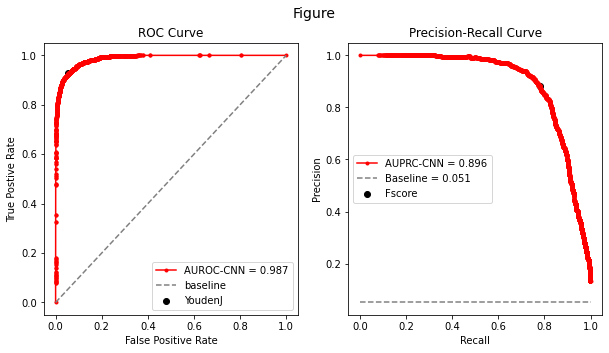

In [115]:
eval_CNN_test = model_CNN.evaluate(X_test_correlations, y_test, verbose = 0)

# Print loss and metrics evaluation test set
print('Test loss = {:.3f}'.format(eval_CNN_test[0]))
print('-----------------------')
print('Test Accuracy  = {:.3f}'.format(eval_CNN_test[5]))
print('Test Precision = {:.3f}'.format(eval_CNN_test[6]))
print('Test Recall    = {:.3f}'.format(eval_CNN_test[7]))
print('Test AUROC     = {:.3f}'.format(eval_CNN_test[8]))
print('Test AUPRC     = {:.3f}'.format(eval_CNN_test[9]))
y_score_CNN_correlations = model_CNN.predict(X_test_correlations)

# calculate ROC and Precision-Recall curves
stats_CNN = plot_ROC_PRC_score(y_test = y_test,
                           y_score = y_score_CNN_correlations,
                           plot = True,
                           type_DL = 'CNN')

## Upper triangular

Test loss = 0.088
-----------------------
Test Accuracy  = 0.967
Test Precision = 0.629
Test Recall    = 0.826
Test AUROC     = 0.959
Test AUPRC     = 0.814


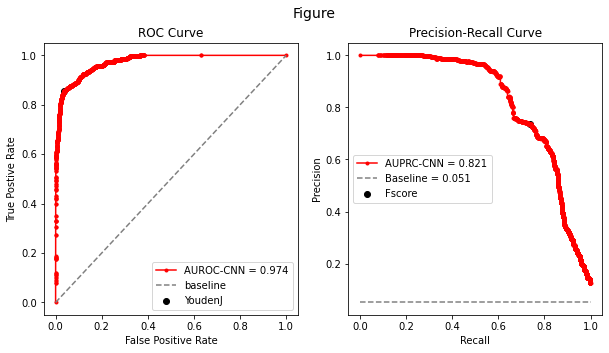

In [116]:
eval_CNN_test = model_CNN.evaluate(X_test_correlations_upper, y_test, verbose = 0)

# Print loss and metrics evaluation test set
print('Test loss = {:.3f}'.format(eval_CNN_test[0]))
print('-----------------------')
print('Test Accuracy  = {:.3f}'.format(eval_CNN_test[5]))
print('Test Precision = {:.3f}'.format(eval_CNN_test[6]))
print('Test Recall    = {:.3f}'.format(eval_CNN_test[7]))
print('Test AUROC     = {:.3f}'.format(eval_CNN_test[8]))
print('Test AUPRC     = {:.3f}'.format(eval_CNN_test[9]))
y_score_CNN_correlations_upper = model_CNN.predict(X_test_correlations_upper)

# calculate ROC and Precision-Recall curves
stats_CNN = plot_ROC_PRC_score(y_test = y_test,
                           y_score = y_score_CNN_correlations_upper,
                           plot = True,
                           type_DL = 'CNN')

In [123]:
def plot_ROC_PRC_score(y_test,
                       y_score_LBBF,
					             y_score_correl,
					             y_score_correl_upper,
                       plot = False,
                       title = 'Figure',
                       type_DL = 'Neural Network',
                       fig_save = None):

  # PR components
  baseline_pr = np.sum(y_test.ravel())/len(y_test.ravel())
  
  #1) LBBF
  prec_NN_LBBF, recall_NN_LBBF, thresholds_PR_LBBF = precision_recall_curve(y_test.ravel(), y_score_LBBF.ravel())
  fscore_LBBF = (2*prec_NN_LBBF*recall_NN_LBBF)/(prec_NN_LBBF + recall_NN_LBBF)
  ix_PR_LBBF = np.argmax(fscore_LBBF)
  avg_prec_LBBF = average_precision_score(y_test.ravel(), y_score_LBBF.ravel())
  
  #2) Correlations
  prec_NN_correl, recall_NN_correl, thresholds_PR_correl = precision_recall_curve(y_test.ravel(), y_score_correl.ravel())
  fscore_correl = (2*prec_NN_correl*recall_NN_correl)/(prec_NN_correl + recall_NN_correl)
  ix_PR_correl = np.argmax(fscore_correl)
  avg_prec_correl = average_precision_score(y_test.ravel(), y_score_correl.ravel())
  
  #3) Correlations Upper
  prec_NN_correl_upper, recall_NN_correl_upper, thresholds_PR_correl_upper = precision_recall_curve(y_test.ravel(), y_score_correl_upper.ravel())
  fscore_correl_upper = (2*prec_NN_correl_upper*recall_NN_correl_upper)/(prec_NN_correl_upper + recall_NN_correl_upper)
  ix_PR_correl_upper = np.argmax(fscore_correl_upper)
  avg_prec_correl_upper = average_precision_score(y_test.ravel(), y_score_correl_upper.ravel())

  if plot is True:
    #Plot Precision-Recall
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,5))

	# 1) LBBF
    ax1.plot(recall_NN_LBBF, prec_NN_LBBF, marker='.', label='AUPRC-'+type_DL+' = {:.3f}'.format(auc(recall_NN_LBBF,prec_NN_LBBF)), color ='mediumblue')
    ax1.plot([0, 1], [baseline_pr, baseline_pr], linestyle='--', label='Baseline = {:.3f}'.format(baseline_pr), color = 'grey')
    ax1.scatter(recall_NN_LBBF[ix_PR_LBBF], prec_NN_LBBF[ix_PR_LBBF], marker='o', color='black', label='Fscore')
    ax1.set_title('Scaled Lower Bound Bayes Factors')
    ax1.set(xlabel='Recall', ylabel='Precision')
    ax1.legend()
	
	# 2) Correlations
    ax2.plot(recall_NN_correl, prec_NN_correl, marker='.', label='AUPRC-'+type_DL+' = {:.3f}'.format(auc(recall_NN_correl,prec_NN_correl)), color ='mediumblue')
    ax2.plot([0, 1], [baseline_pr, baseline_pr], linestyle='--', label='Baseline = {:.3f}'.format(baseline_pr), color = 'grey')
    ax2.scatter(recall_NN_correl[ix_PR_correl], prec_NN_correl[ix_PR_correl], marker='o', color='black', label='Fscore')
    ax2.set_title('Interactions')
    ax2.set(xlabel='Recall', ylabel='Precision')
    ax2.legend()
	
	# 3) Correlations Upper
    ax3.plot(recall_NN_correl_upper, prec_NN_correl_upper, marker='.', label='AUPRC-'+type_DL+' = {:.3f}'.format(auc(recall_NN_correl_upper,prec_NN_correl_upper)), color ='mediumblue')
    ax3.plot([0, 1], [baseline_pr, baseline_pr], linestyle='--', label='Baseline = {:.3f}'.format(baseline_pr), color = 'grey')
    ax3.scatter(recall_NN_correl_upper[ix_PR_correl_upper], prec_NN_correl_upper[ix_PR_correl_upper], marker='o', color='black', label='Fscore')
    ax3.set_title('Interactions: Upper triangular')
    ax3.set(xlabel='Recall', ylabel='Precision')
    ax3.legend()

    fig.suptitle(title, fontsize=14)
    fig.show()
    if fig_save is not None:
      fig.savefig(fig_save)
  # End of if

  # output dict
  thresholds_PR_Stat_LBBF = thresholds_PR_LBBF[ix_PR_LBBF]
  fscore_LBBF = fscore_LBBF[ix_PR_LBBF]
  
  
  output_dict = {'thresholds_PR_Stat_LBBF':thresholds_PR_Stat_LBBF,
                 'fscore_LBBF':fscore_LBBF,
                 'avg_prec_LBBF': avg_prec_LBBF}
  return output_dict

{'avg_prec_LBBF': 0.25536505701776435,
 'fscore_LBBF': 0.35277382645803695,
 'thresholds_PR_Stat_LBBF': 0.00013041496}

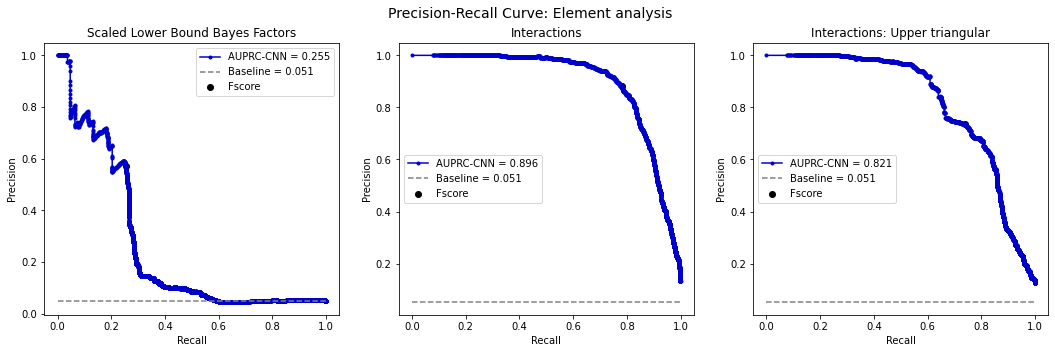

In [125]:
plot_ROC_PRC_score(y_test = y_test,
                       y_score_LBBF = y_score_CNN_element_wise,
					             y_score_correl = y_score_CNN_correlations,
					             y_score_correl_upper = y_score_CNN_correlations_upper,
                       plot = True,
                       title = 'Precision-Recall Curve: Element analysis',
                       type_DL = 'CNN',
                     fig_save = 'fig_ind_analysis.png')

In [126]:
from google.colab import files
files.download("fig_ind_analysis.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>